In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
from matplotlib import pyplot as plt


def get_percentile(perposimp, num_signal_bases_per_reg_region):
    signal_frac = (num_signal_bases_per_reg_region*len(perposimp))/(
                   len(np.ravel(perposimp)) )
    signal_cutoff = np.percentile(perposimp, 100*(1-signal_frac))
    assert signal_cutoff > 0
    
    heights,_,_ = plt.hist(perposimp.ravel(), bins=100, density=True)
    plt.plot([signal_cutoff, signal_cutoff], [0,max(heights)])
    #plt.plot([-signal_cutoff, -signal_cutoff], [0,max(heights)])
    plt.show()
    return signal_cutoff


def get_sigmoid_transformation_func(perposimp, high_signal_point_numbases,
                                    low_signal_point_numbases, highprob=0.9, lowprob=0.1):
    x_high = get_percentile(
        perposimp=perposimp,
        num_signal_bases_per_reg_region=high_signal_point_numbases)
    x_low = get_percentile(
        perposimp=perposimp,
        num_signal_bases_per_reg_region=low_signal_point_numbases)
    
    #solve:
    # 1/(1 + e^-(a*x_low + b)) = lowprob --> lowprob/(1-lowprob) = a*x_low + b
    # 1/(1 + e^-(a*x_high + b)) = highprob --> highprob/(1-highprob) = a*x_high + b
    # highprob/(1-highprob) - lowprob/(1-lowprob) = a*(x_high - x_low)
    # a = (highprob/(1-highprob) - lowprob/(1-lowprob))/(x_high - x_low)
    # b = highprob/(1-highprob) - a*x_high
    a = (highprob/(1-highprob) - lowprob/(1-lowprob))/(x_high - x_low)
    b = (highprob/(1-highprob) - a*x_high)
    
    print(x_high, x_low)
    print(a, b)
    def transformation_func(inp):
        return 1/(1 + np.exp(-(a*inp + b)))
    
    return transformation_func

/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


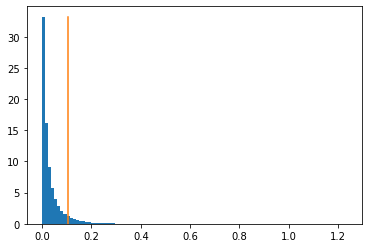

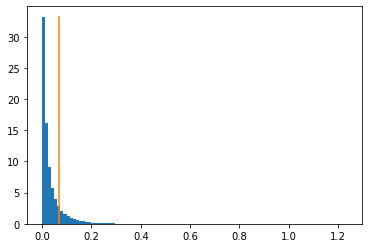

0.10280420018214685 0.06656486007338722
245.2828573095431 -16.21610796409923


In [3]:
import numpy as np
import modisco

onehot_data = np.load('extracted_onehot.npy')[:,:]
hypothetical_data = np.load('extracted_hypothetical_scores.npy')[:,:]
meannorm_hypothetical_data = (hypothetical_data
                              -np.mean(hypothetical_data, axis=-1)[:,:,None])
contrib_data = np.load('extracted_contrib_scores.npy')[:,:]
perposimp_hypmeannorm = np.sum(meannorm_hypothetical_data*onehot_data,axis=-1)
abs_perposimp_hypmeannorm = np.abs(perposimp_hypmeannorm)

sigmoid_transformation_func = get_sigmoid_transformation_func(
                                perposimp=abs_perposimp_hypmeannorm,
                                high_signal_point_numbases=10,
                                low_signal_point_numbases=20)

flanksize=20
contrib_scores_track = modisco.core.DataTrack(name="contrib_scores",
                                 fwd_tracks=contrib_data,
                                 rev_tracks=contrib_data[:,::-1, ::-1])
hypcontrib_scores_track = modisco.core.DataTrack(name="hypcontrib_scores",
                                    fwd_tracks=hypothetical_data,
                                    rev_tracks=hypothetical_data[:,::-1, ::-1])
meannorm_hypcontrib_scores_track = modisco.core.DataTrack(name="meannorm_hypcontrib_scores",
                                    fwd_tracks=meannorm_hypothetical_data,
                                    rev_tracks=meannorm_hypothetical_data[:,::-1, ::-1])
onehot_track = modisco.core.DataTrack(
                 name="onehot", fwd_tracks=onehot_data,
                 rev_tracks=onehot_data[:,::-1, ::-1])
masked_onehot_data = onehot_data*(
    sigmoid_transformation_func(inp=abs_perposimp_hypmeannorm)[:,:,None])
masked_onehot_track = modisco.core.DataTrack(
                        name="masked_onehot",
                        fwd_tracks=masked_onehot_data,
                        rev_tracks=masked_onehot_data[:,::-1, ::-1])
track_set = modisco.core.DataTrackSet(data_tracks=[
                contrib_scores_track, hypcontrib_scores_track,
                meannorm_hypcontrib_scores_track, onehot_track, masked_onehot_track
               ])

coords = []
for example_idx in range(len(onehot_data)):
    #figure out the 6bp window with highest imp
    padded_cumsum = np.array([0]+list(np.cumsum(perposimp_hypmeannorm[example_idx][50:50+41])))
    sliding_window_imp = padded_cumsum[7:] - padded_cumsum[:-7]
    start = np.argmax(sliding_window_imp)+50
    coords.append(modisco.core.Coordinate(
                    example_idx=example_idx, start=start-17,
                    end=start+24, is_revcomp=False))

all_seqlets = [x for x in track_set.create_seqlets(coords=coords, flanks=30)
               if np.sum(x["contrib_scores"].corefwd) > 0]


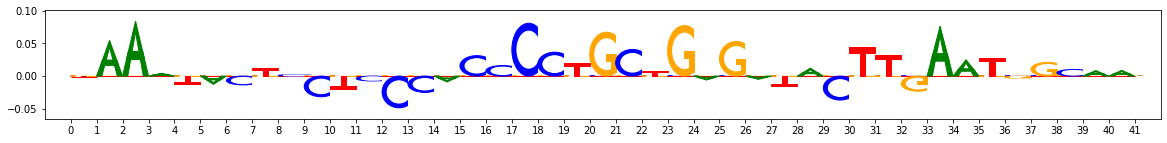

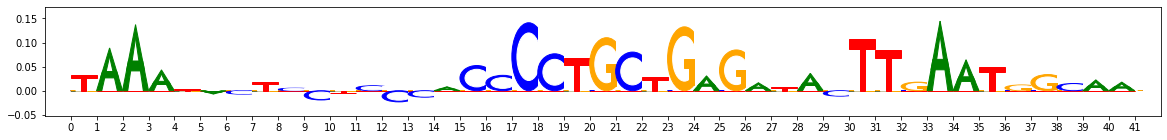

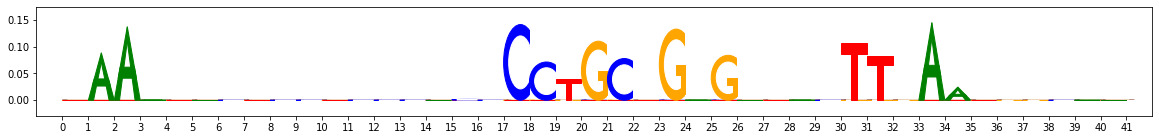

In [4]:
from modisco.visualization import viz_sequence
idx=7
viz_sequence.plot_weights(all_seqlets[idx]["contrib_scores"].corefwd)
viz_sequence.plot_weights(all_seqlets[idx]["meannorm_hypcontrib_scores"].corefwd 
                          *all_seqlets[idx]["onehot"].corefwd)
viz_sequence.plot_weights(all_seqlets[idx]["meannorm_hypcontrib_scores"].corefwd 
                          *all_seqlets[idx]["masked_onehot"].corefwd)

In [5]:
seqlets_subsample = [all_seqlets[i] for i in np.random.RandomState(1).choice(
                     np.arange(len(all_seqlets)), size=5000,replace=False)]

In [6]:
len(seqlets_subsample)

5000

In [7]:
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.util
reload(modisco.util)
import gc
gc.collect()

min_overlap_frac=0.75
affmat_computer = modisco.affinitymat.SequenceAffmatComputer_Impute(
                    metric=modisco.util.l1norm_contin_jaccard_sim,
                    n_jobs=8, min_overlap_frac=min_overlap_frac)

In [8]:
affmat, offsets, isfwdmat = affmat_computer(seqlets_subsample, onehot_trackname="masked_onehot",
                                            hyp_trackname="meannorm_hypcontrib_scores")

np.save("maskedonehotmeannormcontribs_affmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", affmat)
np.save("maskedonehotmeannormcontribs_offsets_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", offsets)
np.save("maskedonehotmeannormcontribs_isfwdmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", isfwdmat)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   38.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:  6.2min
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:  6.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   11.6s
[Parallel(n_jobs=8)]: Done 434 tasks    

In [9]:
np.sum(np.isnan(affmat))/len(np.ravel(affmat))

0.0

In [10]:
affmat = np.load("maskedonehotmeannormcontribs_affmat_recenter_41bpseqlets_0.75.npy")
offsets = np.load("maskedonehotmeannormcontribs_offsets_recenter_41bpseqlets_0.75.npy")
isfwdmat = np.load("maskedonehotmeannormcontribs_isfwdmat_recenter_41bpseqlets_0.75.npy")

In [11]:
import modisco.core
reload(modisco.core)
import modisco.affinitymat
reload(modisco.affinitymat)

flatten = 1
distmat = np.log(1.0/(flatten*np.maximum(affmat,1e-7)) - (1.0/flatten - 1))

n_neighbors = 30
tsne_adapted = modisco.affinitymat.tsne_density_adaptation(dist_mat=distmat,
                                                           perplexity=n_neighbors)
#tsne_adapted = tsne_adapted + np.eye(len(tsne_adapted))*np.max(tsne_adapted, axis=-1)
current_affmat = (tsne_adapted*tsne_adapted.T)
#current_affmat = (tsne_adapted + tsne_adapted.T)/2.0
#make sure there is a self-similarity so there's a reason to leave things in their own cluster
currentaffmatmethod = "tsne-mulT"

#get the number of examples that contain x% of the probability density
"""from matplotlib import pyplot as plt

tsne_adapted_sorted_cumsum = np.cumsum(np.sort(tsne_adapted, axis=-1)[:,::-1],axis=-1)
for percent in [0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999, 1.0]:
    print(percent)
    num_with_density = np.sum(tsne_adapted_sorted_cumsum <= percent, axis=-1)
    print(np.median(num_with_density))
    plt.hist(num_with_density, bins=100)
    plt.show()"""
    

[t-SNE] Computing 4999 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.029s...
[t-SNE] Computed neighbors for 5000 samples in 2.884s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.182927


'from matplotlib import pyplot as plt\n\ntsne_adapted_sorted_cumsum = np.cumsum(np.sort(tsne_adapted, axis=-1)[:,::-1],axis=-1)\nfor percent in [0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999, 1.0]:\n    print(percent)\n    num_with_density = np.sum(tsne_adapted_sorted_cumsum <= percent, axis=-1)\n    print(np.median(num_with_density))\n    plt.hist(num_with_density, bins=100)\n    plt.show()'

In [ ]:
"""nneighb_affmat = nearest_neighb_affmat(affmat=affmat, n_neighbs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
current_affmat = nneighb_affmat*nneighb_affmat.T
currentaffmatmethod = "nneigh-mulT" """

In [ ]:
"""reload(modisco.affinitymat)
nneighb_affmat = modisco.affinitymat.nearest_neighb_affmat_expo_decay(affmat=affmat, n_neighb=50, beta=0.1)
current_affmat = nneighb_affmat*nneighb_affmat.T
currentaffmatmethod = "nneigh-expo-mulT" """

In [ ]:
"""from collections import Counter
reload(modisco.affinitymat)
from modisco.affinitymat import nearest_neighb_affmat
from modisco.affinitymat import get_diffusion_distances
import sklearn.cluster

nneighb_affmat = nearest_neighb_affmat(affmat=affmat, n_neighbs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
dmap = np.real(modisco.affinitymat.get_concat_dmap_coords(affmat=nneighb_affmat, ts=[1],
                                                          k=int(len(nneighb_affmat)/50)))
distmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(dmap, metric='euclidean'))
current_affmat = 1.0/np.exp(distmat)
currentaffmatmethod = "nneigh-diffusionmap" """

In [12]:
"""kmeans_clustdist = sklearn.cluster.KMeans(n_clusters=int(len(nneighb_affmat)/100),
                                          n_init=100, random_state=1234).fit_transform(dmap)
the_clustering = np.argmin(kmeans_clustdist,axis=-1)"""

import leidenalg
from collections import Counter

print("affmat method",currentaffmatmethod)

#current_affmat = current_affmat*(1-np.eye(len(current_affmat)))

#get Leiden averaged over different seeds
averaging_rounds = 0
#keep top 5% for speed
current_affmat = current_affmat*(current_affmat>np.percentile(current_affmat.ravel(), q=95))
for round_num in range(averaging_rounds):
    current_affmat = modisco.affinitymat.average_over_different_seeds(
                        affmat=current_affmat,
                        clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                partitiontype=leidenalg.ModularityVertexPartition,
                                                n_iterations=1),
                        nseeds=200)

the_clustering = modisco.affinitymat.take_best_over_different_seeds(affmat=current_affmat,
                                                clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                    partitiontype=leidenalg.ModularityVertexPartition,
                                                    n_iterations=-1),
                                                nseeds=10)
print(Counter(the_clustering))

affmat method tsne-mulT


Quality: 0.9447969101225614
Quality: 0.9449257160526717
Quality: 0.9449696241862698
Quality: 0.9449865429303244

Counter({0: 299, 1: 259, 2: 202, 3: 197, 4: 178, 5: 157, 6: 155, 7: 151, 8: 145, 9: 143, 10: 124, 11: 117, 12: 116, 13: 107, 14: 97, 15: 96, 16: 91, 17: 83, 18: 82, 20: 80, 19: 80, 21: 73, 22: 72, 23: 70, 24: 67, 25: 65, 26: 62, 27: 60, 28: 54, 29: 50, 30: 49, 31: 48, 32: 45, 34: 45, 33: 45, 35: 44, 36: 36, 37: 34, 38: 34, 39: 33, 40: 31, 41: 29, 42: 28, 43: 27, 44: 26, 45: 26, 46: 24, 47: 22, 48: 22, 49: 21, 50: 19, 53: 18, 51: 18, 52: 18, 55: 17, 54: 17, 57: 16, 58: 16, 59: 16, 56: 16, 64: 15, 63: 15, 60: 15, 62: 15, 61: 15, 65: 14, 67: 14, 66: 14, 68: 14, 71: 13, 69: 13, 70: 13, 72: 13, 75: 12, 73: 12, 74: 12, 79: 11, 78: 11, 77: 11, 76: 11, 83: 10, 84: 10, 82: 10, 81: 10, 85: 10, 80: 10, 86: 9, 88: 8, 87: 8, 89: 8, 90: 8, 94: 7, 91: 7, 96: 7, 95: 7, 92: 7, 97: 7, 98: 7, 93: 7, 99: 6, 101: 6, 100: 6, 102: 6, 105: 5, 103: 5, 108: 5, 107: 5, 104: 5, 106: 5, 110: 4, 117: 4, 

In [30]:
reload(modisco.core)
import modisco.visualization
from modisco.visualization import viz_sequence
from collections import OrderedDict


def get_seqlets_and_seqletoffsets_for_aggregated_seqlet(seqlets, in_cluster_mask, distmat, isfwdmat, offsets):
    seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets])
    #anchor = np.argmin(np.sum(distmat[:,in_cluster_mask],axis=-1)
    #                   +((in_cluster_mask==False)*np.inf))
    anchor = np.argmax(seqletimps*in_cluster_mask) #highest imp for anchor; works better than exemplar
    #TODO: probably pick a better "consensus" orientation
    sortinfo = np.argsort(np.median(distmat[in_cluster_mask][:,in_cluster_mask], axis=-1))
    isfwdinfo = isfwdmat[anchor, in_cluster_mask][sortinfo]
    offsetsinfo = offsets[anchor, in_cluster_mask][sortinfo]
    seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in
                                          zip(seqlets, in_cluster_mask) if incluster]
    seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in sortinfo]
    oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                   for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
    #third argument returns the indices for the seqlets in sorted order
    return (oriented_seqlets_in_cluster, offsetsinfo,
            np.arange(len(in_cluster_mask))[in_cluster_mask][sortinfo],
            sortinfo)


def get_aggregated_seqlet(seqlets, in_cluster_mask, distmat, isfwdmat, offsets):
    oriented_seqlets_in_cluster, offsetsinfo, _, seqlets_sortinfo =\
        get_seqlets_and_seqletoffsets_for_aggregated_seqlet(
            seqlets=seqlets, in_cluster_mask=in_cluster_mask, distmat=distmat,
            isfwdmat=isfwdmat, offsets=offsets)
    aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:],
                                                      offsets=offsetsinfo[:])
    inverse_sortinfo = np.zeros(len(seqlets_sortinfo)).astype("int64")
    inverse_sortinfo[seqlets_sortinfo] = np.arange(len(seqlets_sortinfo))
    return aggregated_seqlet, inverse_sortinfo


#set the cluster to -1 for all cases with fewer than min_cluster_size in the cluster
def refine_clusters_by_size(the_clustering, min_cluster_size):
    new_clustering = np.ones_like(the_clustering)*-1
    for idx in range(0, max(the_clustering)+1):
        in_cluster_mask = idx==the_clustering
        num_in_cluster = sum(in_cluster_mask)
        if (num_in_cluster >= min_cluster_size):
            new_clustering[in_cluster_mask] = idx
    return new_clustering


def get_ic_weighting(aggregated_seqlet, onehot_trackname, minperposcountfrac):
    per_pos_ic = modisco.util.compute_per_position_ic(
                            ppm=aggregated_seqlet[onehot_trackname].fwd,
                            background=np.array([0.27, 0.23, 0.23, 0.27]),
                            pseudocount=0.001)
    perpos_count_frac_support = (aggregated_seqlet.position_counts/np.max(
                                    aggregated_seqlet.position_counts))
    perpos_count_meetsthresh = perpos_count_frac_support > minperposcountfrac
    ic_weighting = per_pos_ic*perpos_count_meetsthresh
    ic_weighting = ic_weighting/np.sum(ic_weighting)
    return ic_weighting


def create_weighted_seqlet(seqlet, flank_size, weighting_inc_flanks, onehot_trackname, hyp_trackname):
    new_seqlet = modisco.core.Seqlet(coor=seqlet.coor)
    new_hyp_seqletdata = modisco.core.SeqletData(
                            left_flank=flank_size, right_flank=flank_size,
                            fwd=seqlet[hyp_trackname].get_core_with_flank(
                                    left=flank_size, right=flank_size, is_revcomp=False),
                            rev=seqlet[hyp_trackname].get_core_with_flank(
                                    left=flank_size, right=flank_size, is_revcomp=True))
    new_seqlet[hyp_trackname] = new_hyp_seqletdata
    fwd_onehot = seqlet[onehot_trackname].get_core_with_flank(
                    left=flank_size, right=flank_size, is_revcomp=False)
    rev_onehot = seqlet[onehot_trackname].get_core_with_flank(
                    left=flank_size, right=flank_size, is_revcomp=True)
    masked_fwd_onehot = fwd_onehot*weighting_inc_flanks[:,None]
    masked_rev_onehot = rev_onehot*weighting_inc_flanks[::-1][:,None]
    new_seqlet[onehot_trackname] = modisco.core.SeqletData(
                                        left_flank=flank_size, right_flank=flank_size,
                                        fwd=masked_fwd_onehot, rev=masked_rev_onehot)
    return new_seqlet


#get exemplars where the one-hot encoding is weighted by the information content
# of the aggregate motif
def get_exemplars(the_clustering, distmat, isfwdmat, offsets,
                  seqlets_per_exemplar,
                  onehot_trackname,
                  hyp_trackname,
                  minperposcountfrac=0.8, flank_size=20):
    cluster_idx_to_weighted_exemplars = OrderedDict()
    cluster_idx_to_unweighted_exemplars = OrderedDict()
    cluster_idx_to_aggregated_seqlet = OrderedDict()
    for cluster_idx in range(max(the_clustering)+1):
        in_cluster_mask = cluster_idx==the_clustering
        num_exemplars_for_cluster = int(np.ceil(sum(in_cluster_mask)/seqlets_per_exemplar))
        #get the indices of the exemplars relative to the within-cluster set
        rel_exemplar_indices = modisco.util.facility_locator(
            distmat=distmat[in_cluster_mask][:,in_cluster_mask],
            num_exemplars=num_exemplars_for_cluster)
        #get the aggregated seqlet, as well as the mapping from
        # rel_idx --> idx_of_seqlet_in aggregated_seqlet.seqlets
        aggregated_seqlet, rel_idx_to_sorted_idx = get_aggregated_seqlet(
            seqlets=seqlets_subsample, in_cluster_mask=in_cluster_mask,
            distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
        cluster_idx_to_aggregated_seqlet[cluster_idx] = aggregated_seqlet
        #print(cluster_idx)
        #viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        #Get the information-content-based weighting of positions in the
        # aggregated seqlet
        ic_weighting = get_ic_weighting(aggregated_seqlet=aggregated_seqlet,
                                        onehot_trackname=onehot_trackname,
                                        minperposcountfrac=minperposcountfrac)
        weighted_exemplar_seqlets = []
        unweighted_exemplar_seqlets = []
        #iterate over the exemplars, weight by ic, create new "weighted" exemplars
        for rel_exemplar_idx in rel_exemplar_indices:
            exemplar_seqlet = aggregated_seqlet.seqlets[rel_idx_to_sorted_idx[rel_exemplar_idx]]
            offset_wrt_aggseqlet_start = aggregated_seqlet.offsets[rel_idx_to_sorted_idx[rel_exemplar_idx]]
            #pad with zeros as needed to reach the target flank length
            ic_weight_at_exemplar_inc_flanks = np.concatenate(
                [np.zeros(max(flank_size-offset_wrt_aggseqlet_start,0)),
                 ic_weighting[
                    max(offset_wrt_aggseqlet_start-flank_size,0):
                    offset_wrt_aggseqlet_start+len(exemplar_seqlet)+flank_size],
                 np.zeros(max(flank_size - 
                             (len(ic_weighting)-(offset_wrt_aggseqlet_start
                                                 +len(exemplar_seqlet))),0))],axis=0)
            #normalize to sum to 1
            ic_weight_at_exemplar_inc_flanks = (
                    ic_weight_at_exemplar_inc_flanks/np.sum(ic_weight_at_exemplar_inc_flanks))
            weighted_exemplar_seqlet = create_weighted_seqlet(
                seqlet=exemplar_seqlet, flank_size=flank_size,
                weighting_inc_flanks=ic_weight_at_exemplar_inc_flanks,
                onehot_trackname=onehot_trackname,
                hyp_trackname=hyp_trackname)
            weighted_exemplar_seqlets.append(weighted_exemplar_seqlet)
            unweighted_exemplar_seqlets.append(exemplar_seqlet)
        cluster_idx_to_weighted_exemplars[cluster_idx] = weighted_exemplar_seqlets
        cluster_idx_to_unweighted_exemplars[cluster_idx] = unweighted_exemplar_seqlets
    return cluster_idx_to_aggregated_seqlet, cluster_idx_to_weighted_exemplars, cluster_idx_to_unweighted_exemplars



In [37]:
refined_clustering = refine_clusters_by_size(
    the_clustering=the_clustering, min_cluster_size=20)
distmat_for_exemplars = np.log(1.0/(np.maximum(affmat,1e-7)))
(cluster_idx_to_aggregated_seqlet,
 cluster_to_weighted_exemplars,
 cluster_to_unweighted_exemplars) = get_exemplars(
    the_clustering=refined_clustering, distmat=distmat_for_exemplars,
    isfwdmat=isfwdmat, offsets=offsets, seqlets_per_exemplar=20,
    onehot_trackname="onehot",
    hyp_trackname="meannorm_hypcontrib_scores")

In [38]:
#compute exemplar distances
from collections import OrderedDict
cluster_to_weighted_exemplar_sims = OrderedDict()
cluster_to_unweighted_exemplar_sims = OrderedDict()
for cluster_idx in cluster_to_weighted_exemplars:
    weighted_exemplars = cluster_to_weighted_exemplars[cluster_idx]
    weighted_exemplar_affmat_result = affmat_computer(seqlets=weighted_exemplars,
                                    other_seqlets=seqlets_subsample,
                                    onehot_trackname="onehot",
                                    hyp_trackname="meannorm_hypcontrib_scores",
                                    verbose=False)
    cluster_to_weighted_exemplar_sims[cluster_idx] = weighted_exemplar_affmat_result
    unweighted_exemplars = cluster_to_unweighted_exemplars[cluster_idx]
    unweighted_exemplar_affmat_result = affmat_computer(seqlets=unweighted_exemplars,
                                    other_seqlets=seqlets_subsample,
                                    onehot_trackname="onehot",
                                    hyp_trackname="meannorm_hypcontrib_scores",
                                    verbose=False)
    cluster_to_unweighted_exemplar_sims[cluster_idx] = unweighted_exemplar_affmat_result

0
num seqlets 299


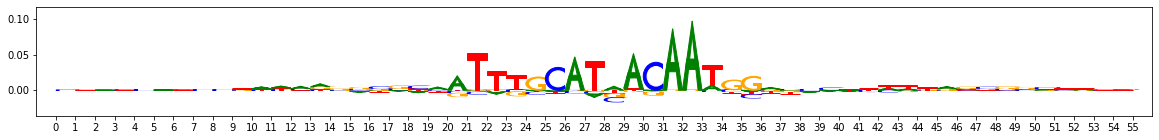

Weighted exemplar continjaccard sim


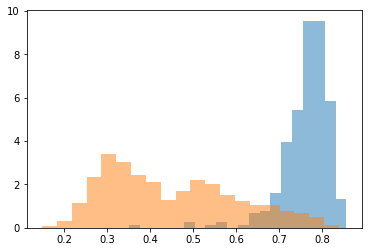

Unweighted exemplar continjaccard sim


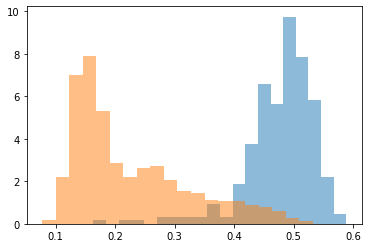

1
num seqlets 259


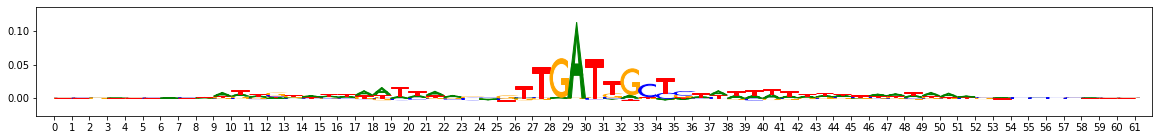

Weighted exemplar continjaccard sim


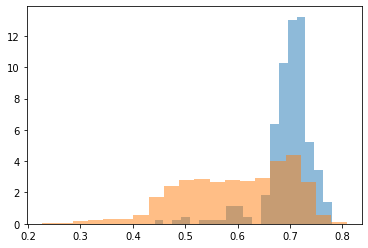

Unweighted exemplar continjaccard sim


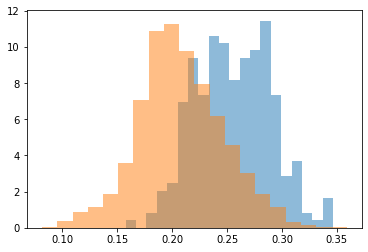

2
num seqlets 202


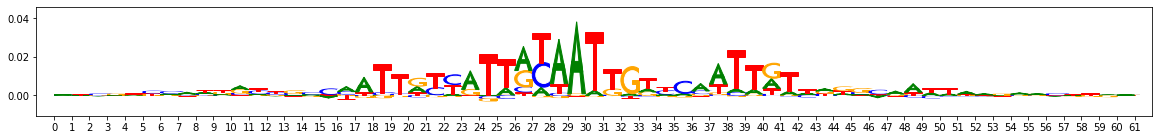

Weighted exemplar continjaccard sim


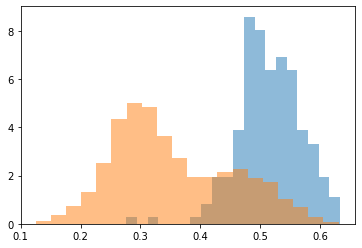

Unweighted exemplar continjaccard sim


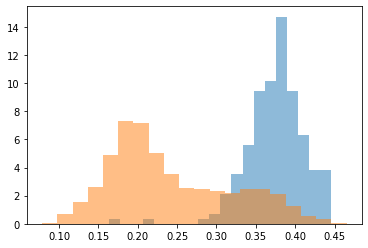

3
num seqlets 197


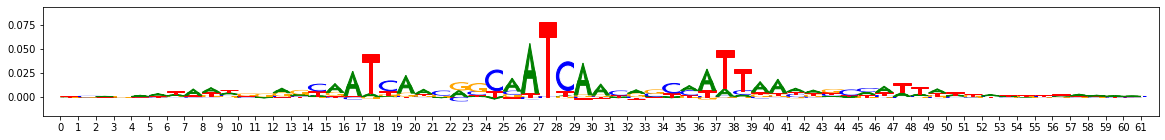

Weighted exemplar continjaccard sim


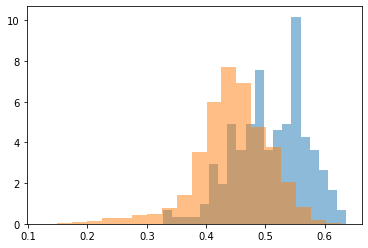

Unweighted exemplar continjaccard sim


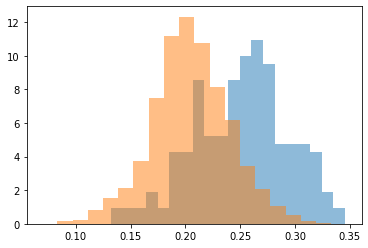

4
num seqlets 178


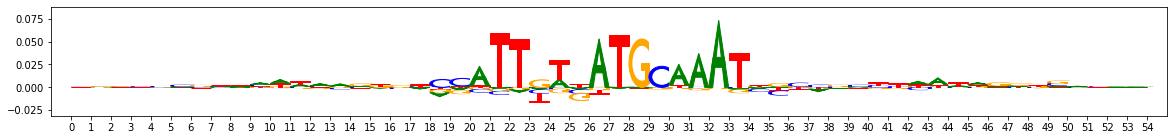

Weighted exemplar continjaccard sim


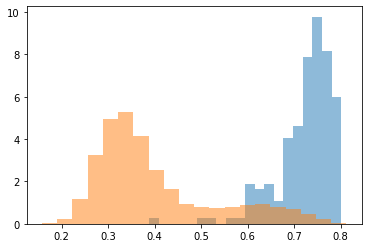

Unweighted exemplar continjaccard sim


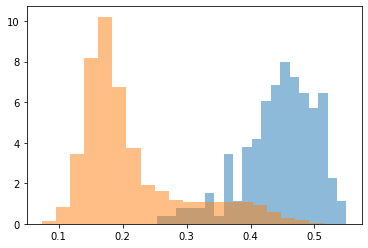

5
num seqlets 157


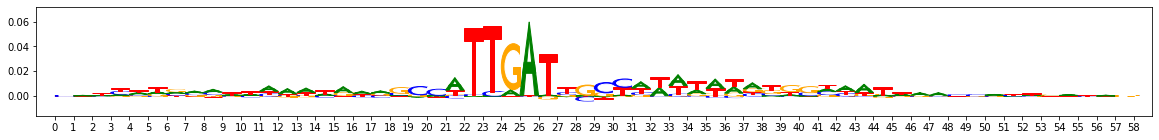

Weighted exemplar continjaccard sim


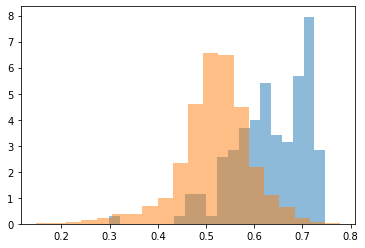

Unweighted exemplar continjaccard sim


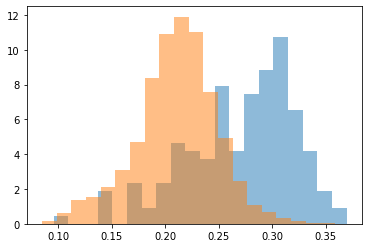

6
num seqlets 155


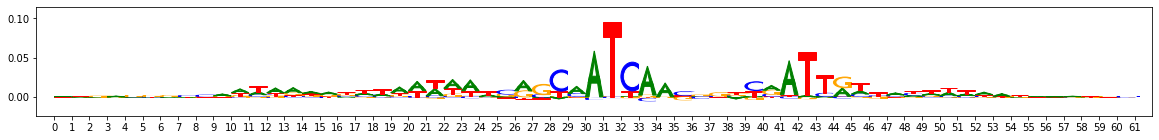

Weighted exemplar continjaccard sim


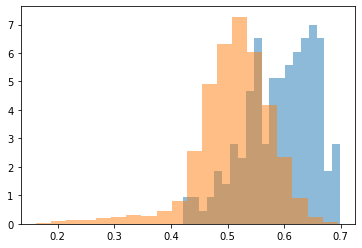

Unweighted exemplar continjaccard sim


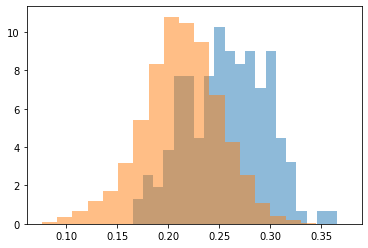

7
num seqlets 151


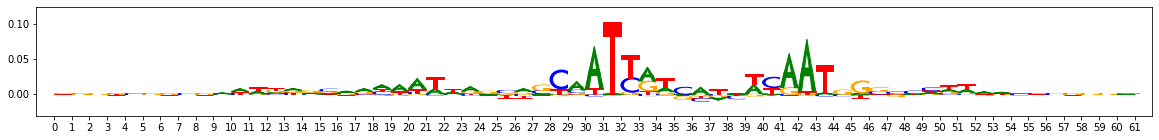

Weighted exemplar continjaccard sim


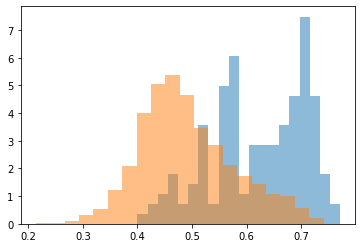

Unweighted exemplar continjaccard sim


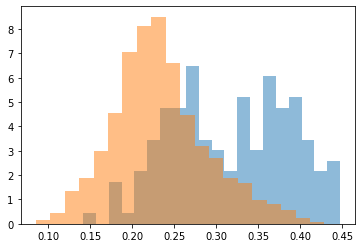

8
num seqlets 145


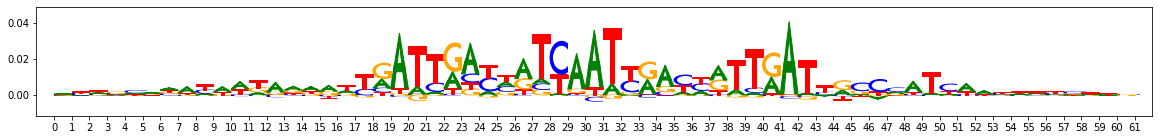

Weighted exemplar continjaccard sim


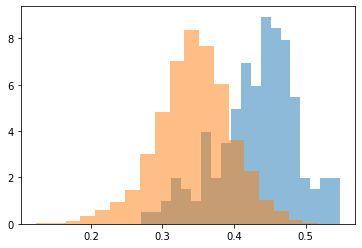

Unweighted exemplar continjaccard sim


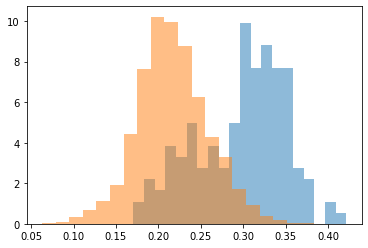

9
num seqlets 143


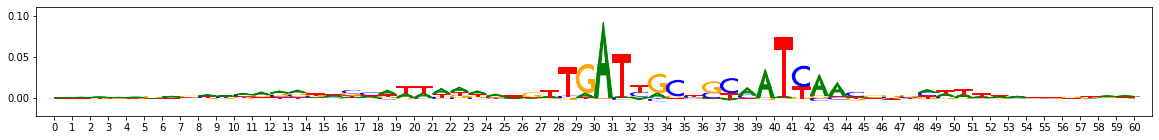

Weighted exemplar continjaccard sim


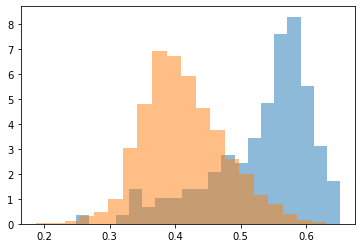

Unweighted exemplar continjaccard sim


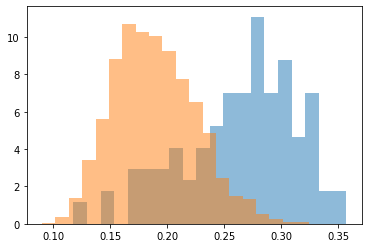

10
num seqlets 124


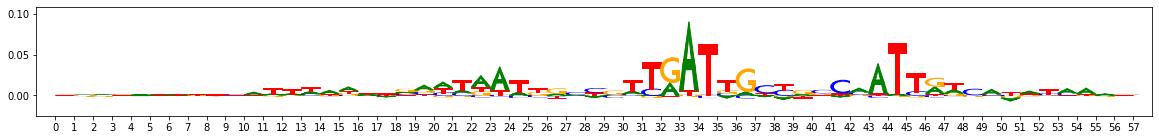

Weighted exemplar continjaccard sim


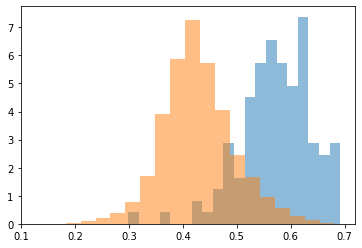

Unweighted exemplar continjaccard sim


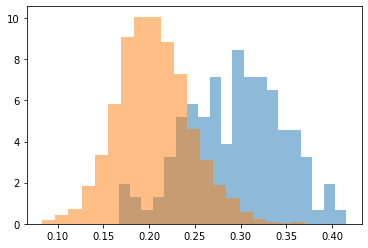

11
num seqlets 117


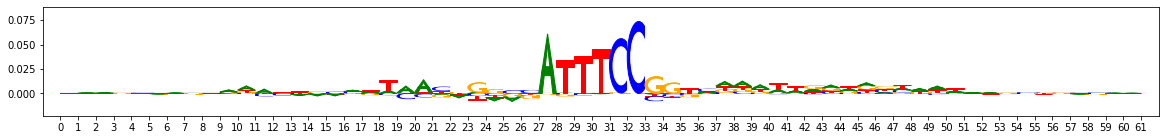

Weighted exemplar continjaccard sim


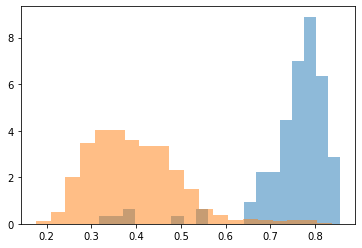

Unweighted exemplar continjaccard sim


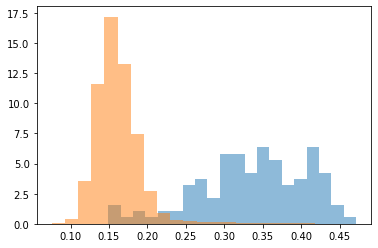

12
num seqlets 116


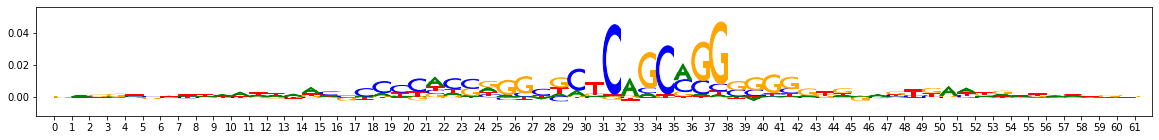

Weighted exemplar continjaccard sim


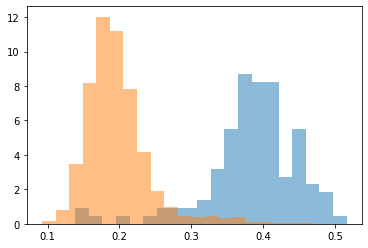

Unweighted exemplar continjaccard sim


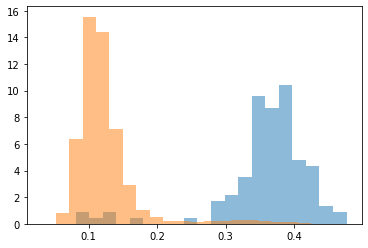

13
num seqlets 107


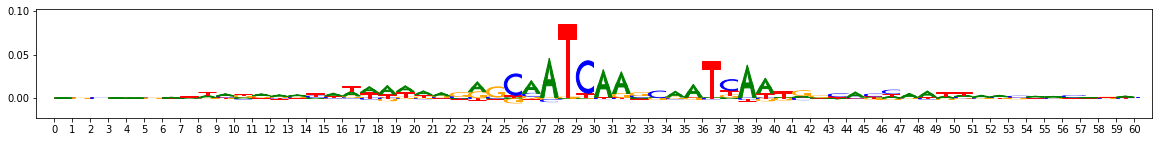

Weighted exemplar continjaccard sim


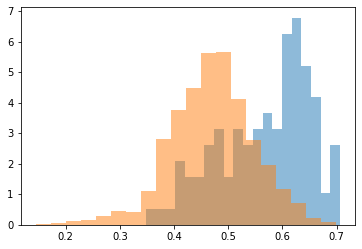

Unweighted exemplar continjaccard sim


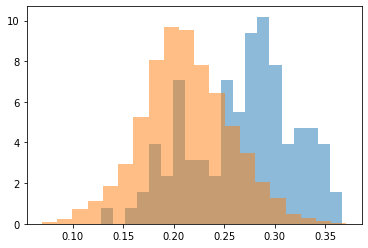

14
num seqlets 97


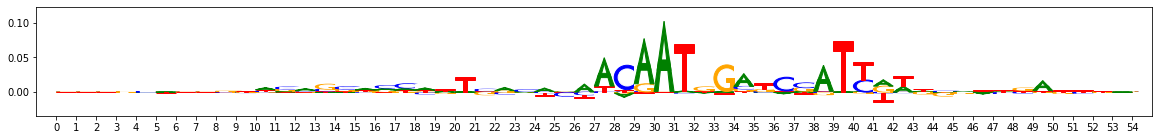

Weighted exemplar continjaccard sim


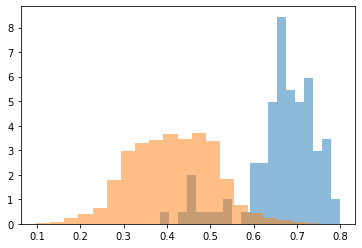

Unweighted exemplar continjaccard sim


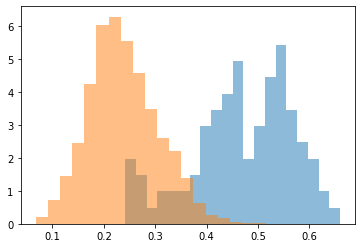

15
num seqlets 96


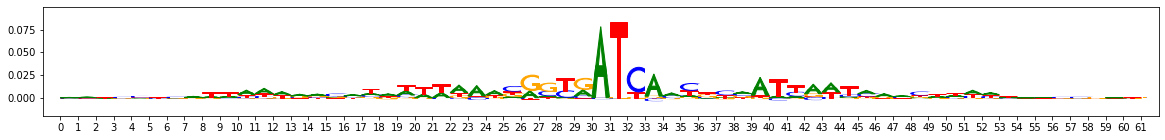

Weighted exemplar continjaccard sim


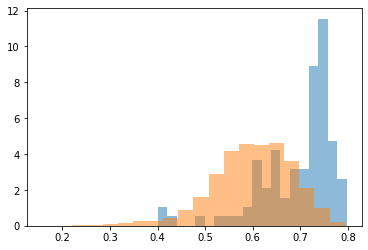

Unweighted exemplar continjaccard sim


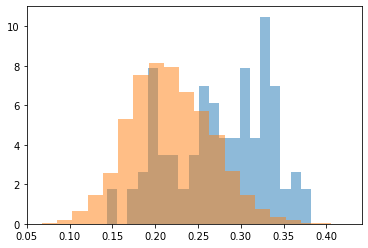

16
num seqlets 91


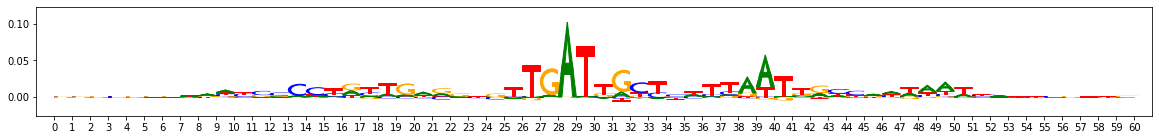

Weighted exemplar continjaccard sim


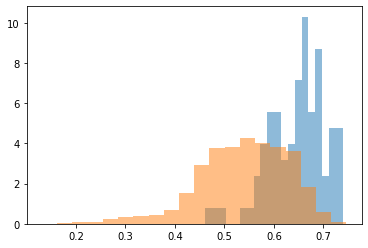

Unweighted exemplar continjaccard sim


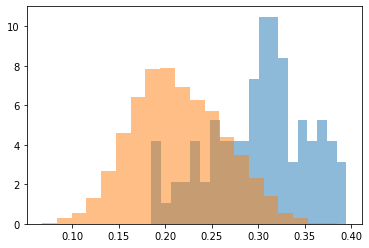

17
num seqlets 83


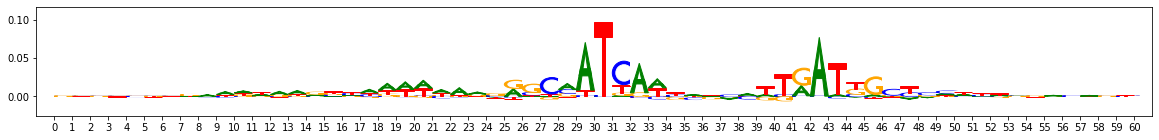

Weighted exemplar continjaccard sim


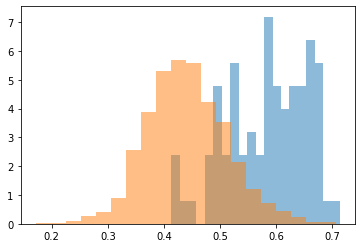

Unweighted exemplar continjaccard sim


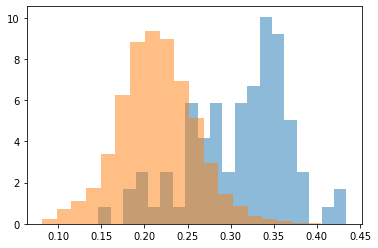

18
num seqlets 82


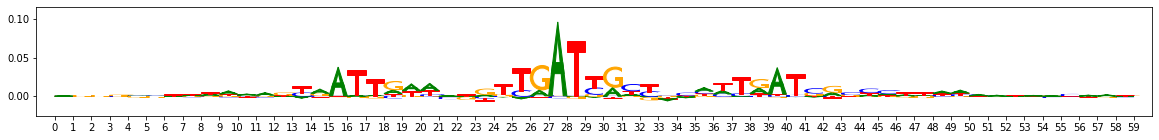

Weighted exemplar continjaccard sim


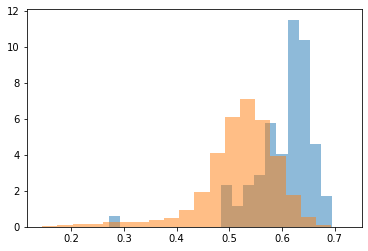

Unweighted exemplar continjaccard sim


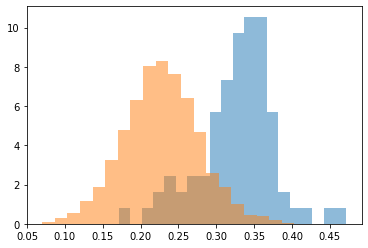

19
num seqlets 80


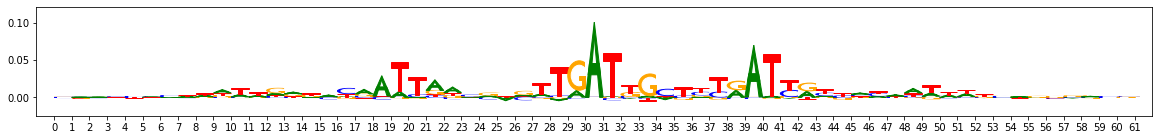

Weighted exemplar continjaccard sim


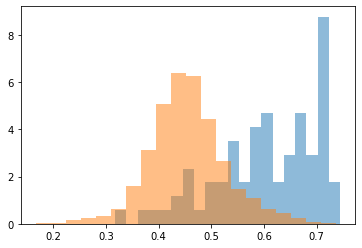

Unweighted exemplar continjaccard sim


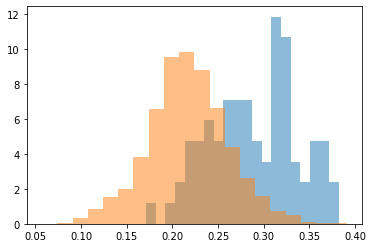

20
num seqlets 80


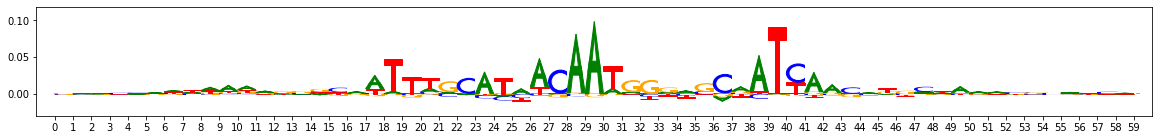

Weighted exemplar continjaccard sim


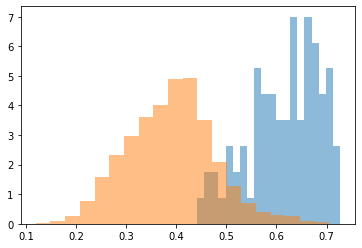

Unweighted exemplar continjaccard sim


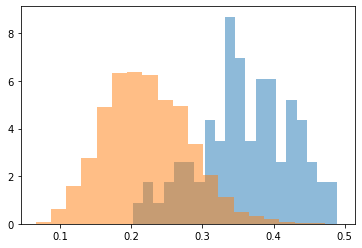

21
num seqlets 73


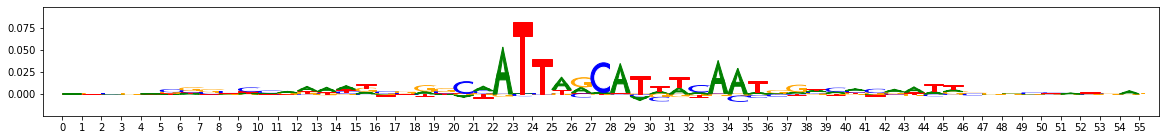

Weighted exemplar continjaccard sim


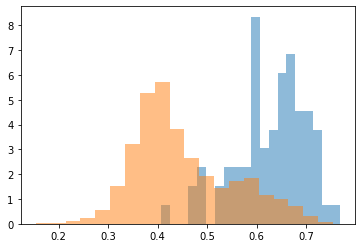

Unweighted exemplar continjaccard sim


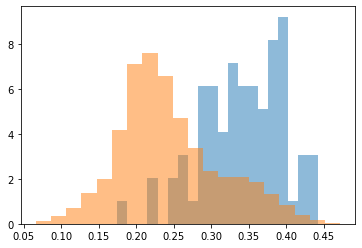

22
num seqlets 72


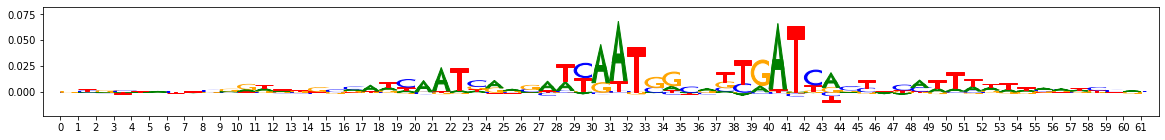

Weighted exemplar continjaccard sim


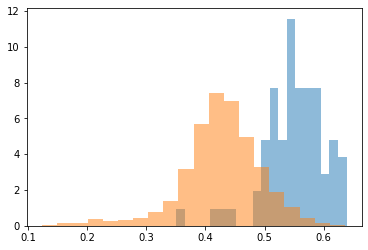

Unweighted exemplar continjaccard sim


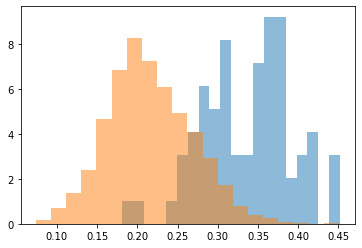

23
num seqlets 70


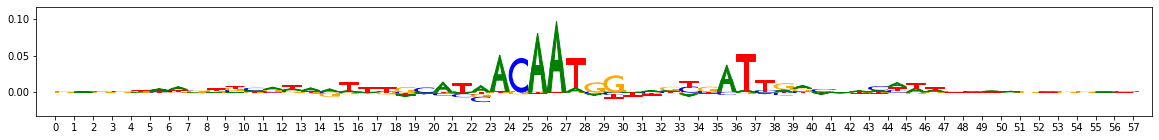

Weighted exemplar continjaccard sim


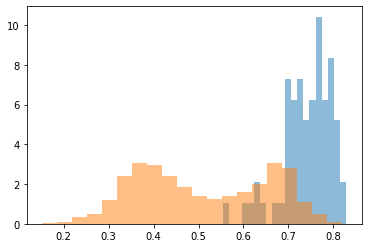

Unweighted exemplar continjaccard sim


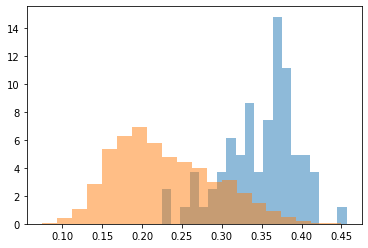

24
num seqlets 67


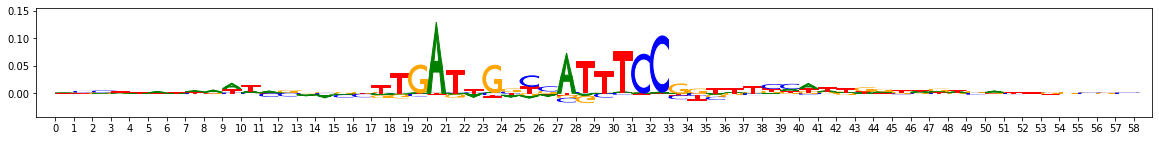

Weighted exemplar continjaccard sim


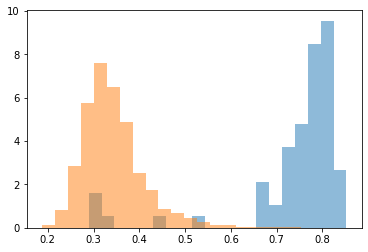

Unweighted exemplar continjaccard sim


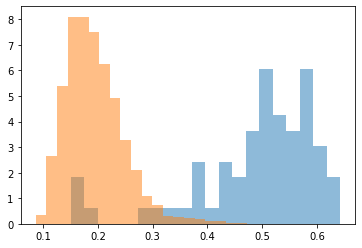

25
num seqlets 65


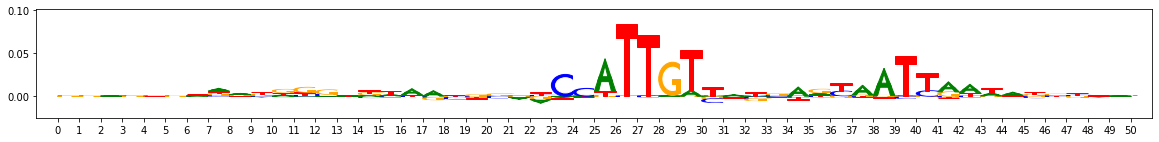

Weighted exemplar continjaccard sim


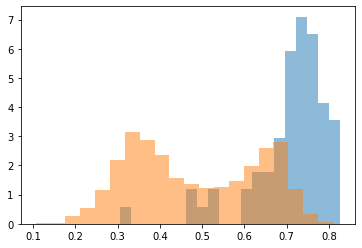

Unweighted exemplar continjaccard sim


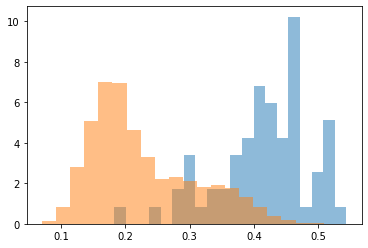

26
num seqlets 62


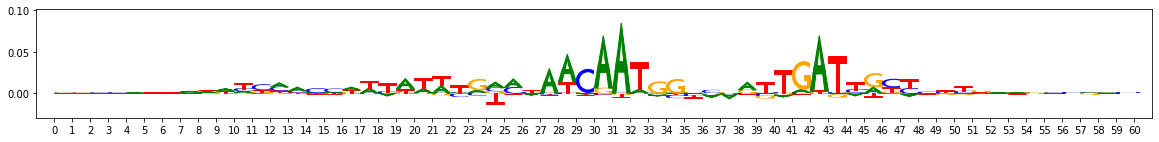

Weighted exemplar continjaccard sim


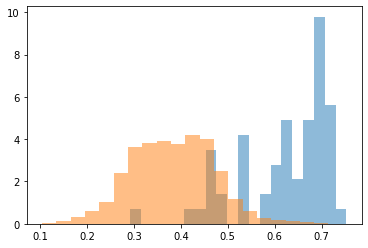

Unweighted exemplar continjaccard sim


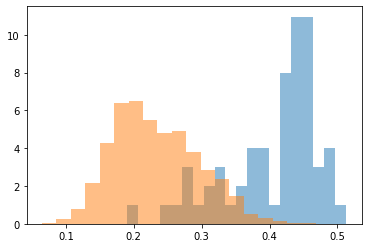

27
num seqlets 60


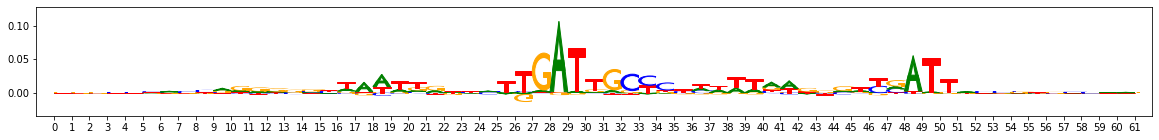

Weighted exemplar continjaccard sim


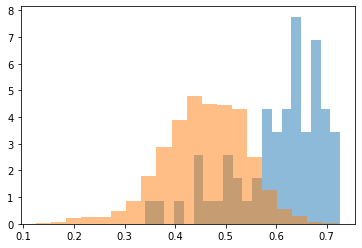

Unweighted exemplar continjaccard sim


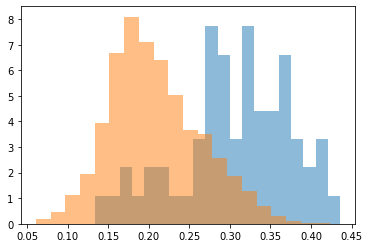

28
num seqlets 54


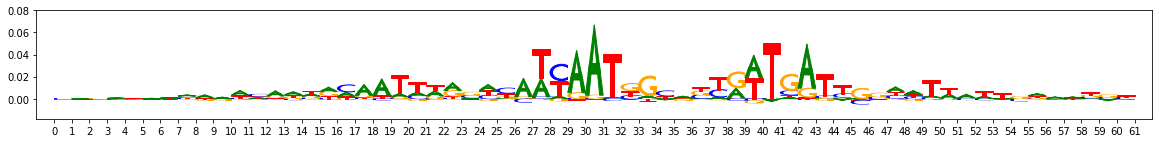

Weighted exemplar continjaccard sim


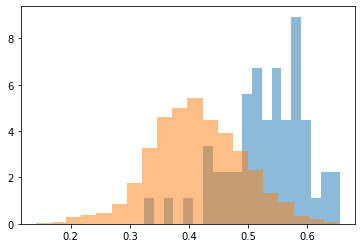

Unweighted exemplar continjaccard sim


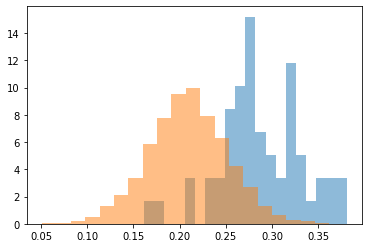

29
num seqlets 50


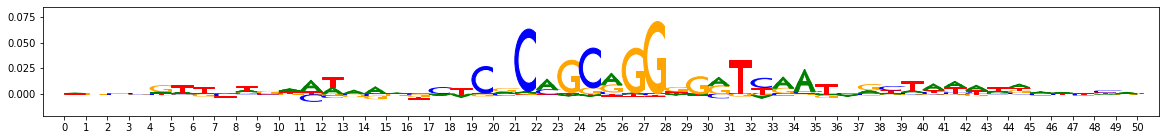

Weighted exemplar continjaccard sim


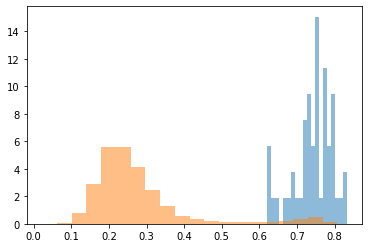

Unweighted exemplar continjaccard sim


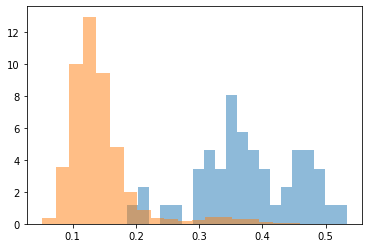

30
num seqlets 49


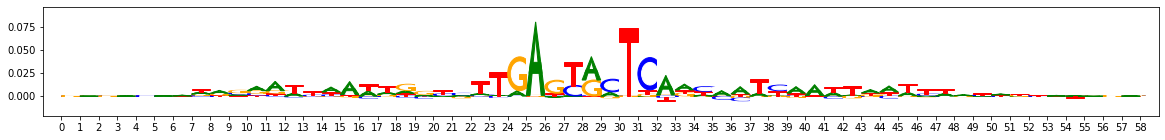

Weighted exemplar continjaccard sim


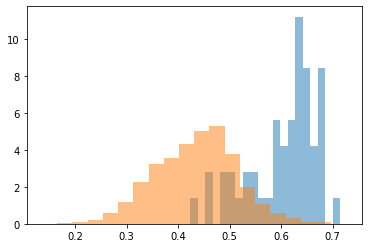

Unweighted exemplar continjaccard sim


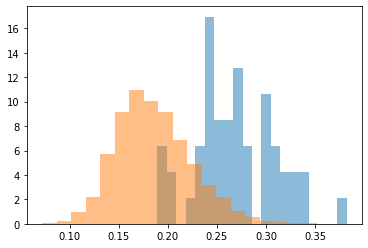

31
num seqlets 48


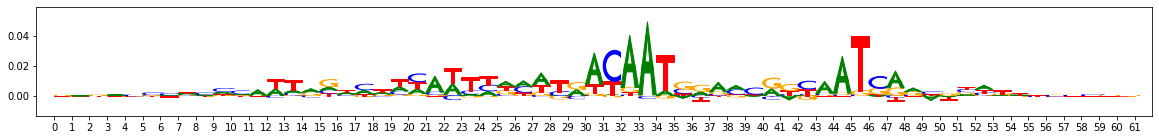

Weighted exemplar continjaccard sim


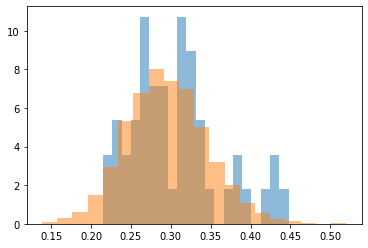

Unweighted exemplar continjaccard sim


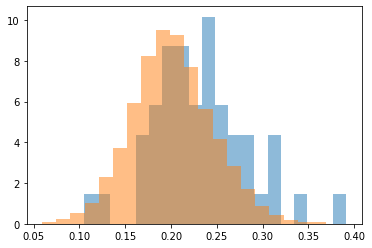

32
num seqlets 45


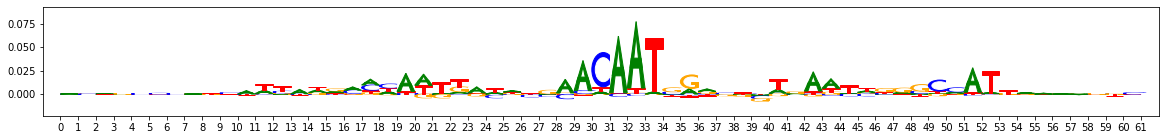

Weighted exemplar continjaccard sim


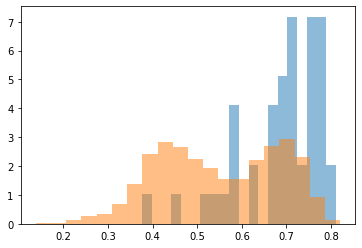

Unweighted exemplar continjaccard sim


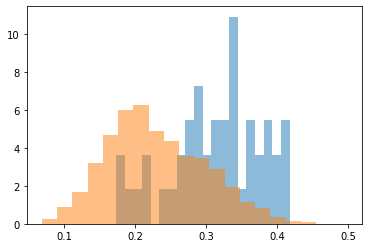

33
num seqlets 45


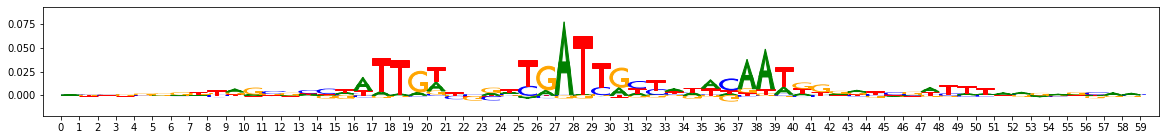

Weighted exemplar continjaccard sim


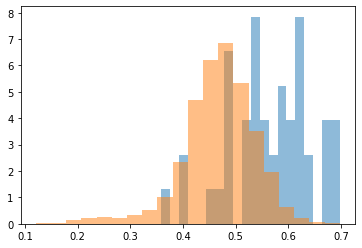

Unweighted exemplar continjaccard sim


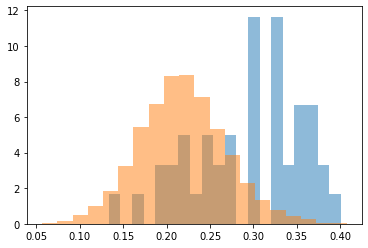

34
num seqlets 45


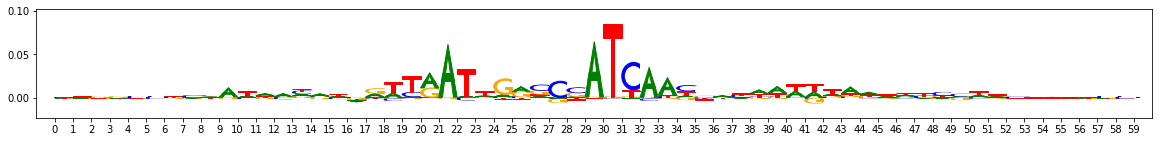

Weighted exemplar continjaccard sim


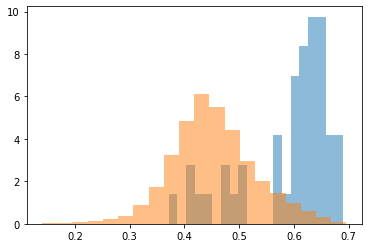

Unweighted exemplar continjaccard sim


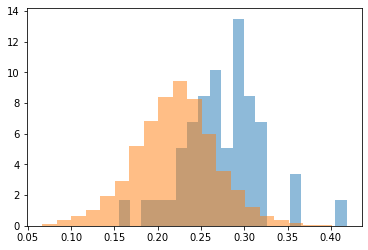

35
num seqlets 44


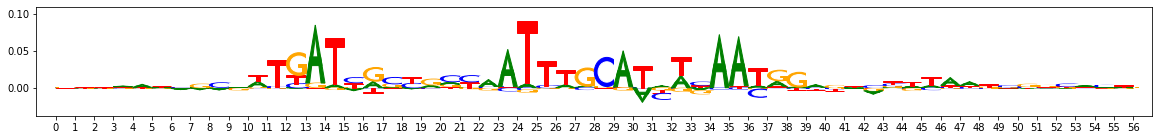

Weighted exemplar continjaccard sim


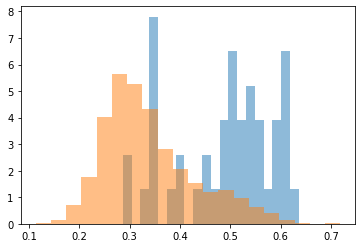

Unweighted exemplar continjaccard sim


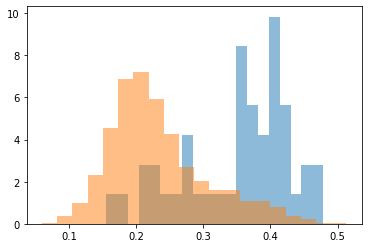

36
num seqlets 36


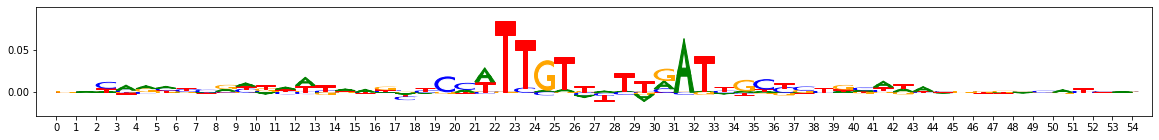

Weighted exemplar continjaccard sim


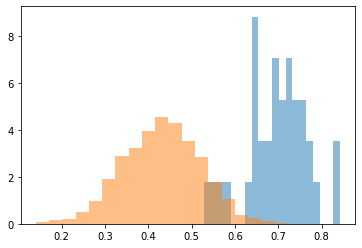

Unweighted exemplar continjaccard sim


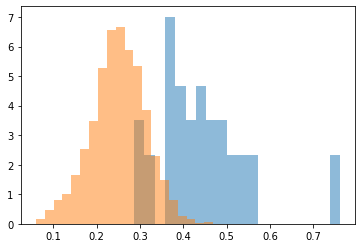

37
num seqlets 34


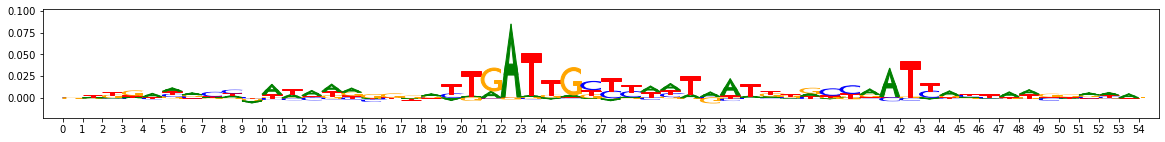

Weighted exemplar continjaccard sim


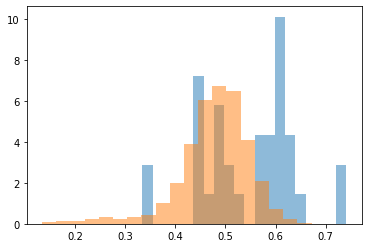

Unweighted exemplar continjaccard sim


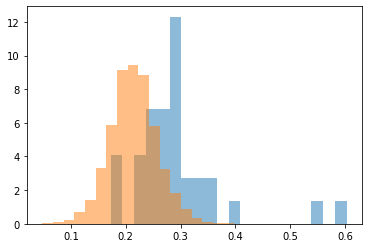

38
num seqlets 34


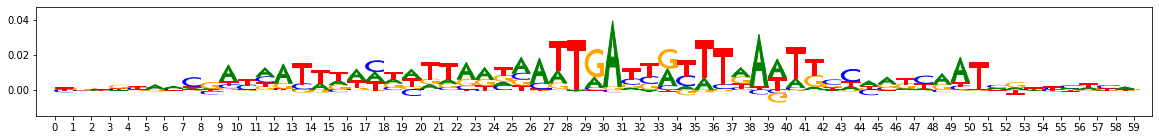

Weighted exemplar continjaccard sim


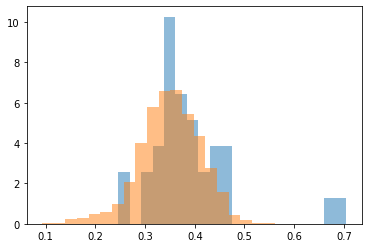

Unweighted exemplar continjaccard sim


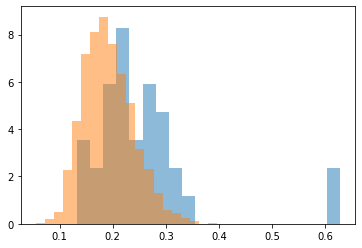

39
num seqlets 33


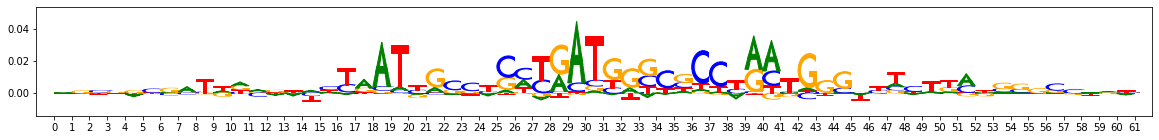

Weighted exemplar continjaccard sim


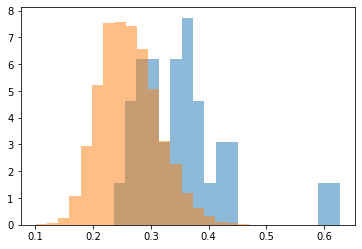

Unweighted exemplar continjaccard sim


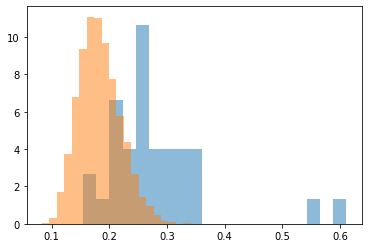

40
num seqlets 31


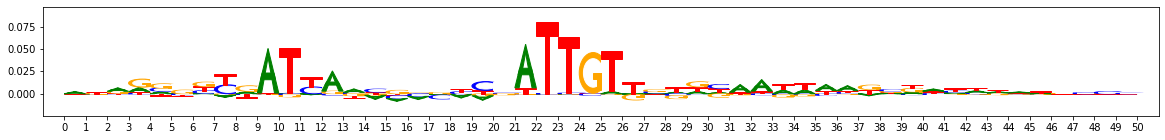

Weighted exemplar continjaccard sim


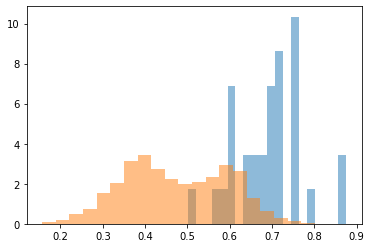

Unweighted exemplar continjaccard sim


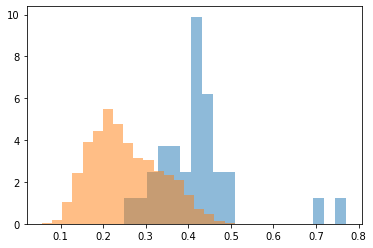

41
num seqlets 29


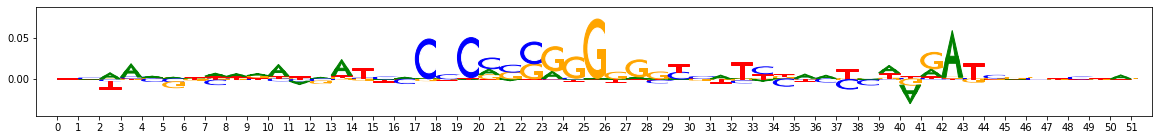

Weighted exemplar continjaccard sim


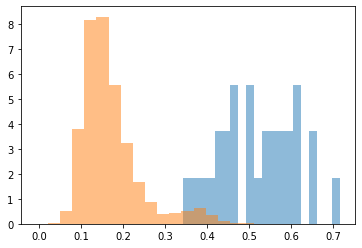

Unweighted exemplar continjaccard sim


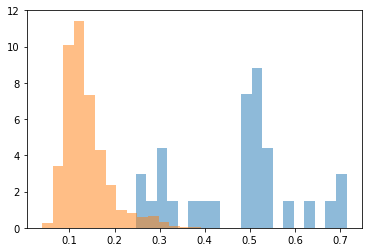

42
num seqlets 28


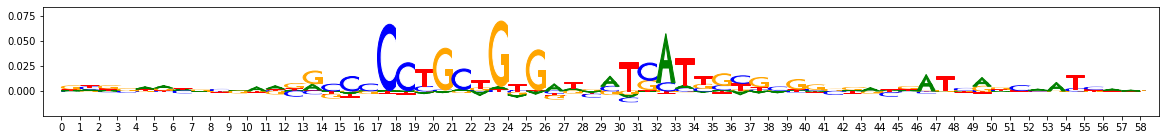

Weighted exemplar continjaccard sim


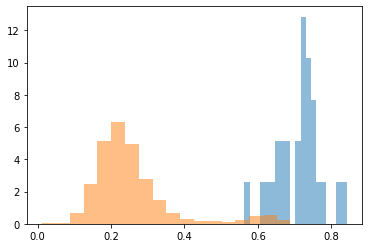

Unweighted exemplar continjaccard sim


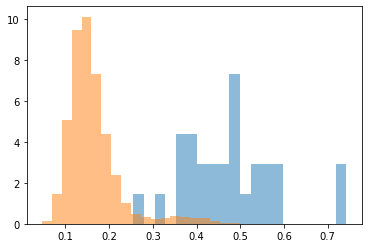

43
num seqlets 27


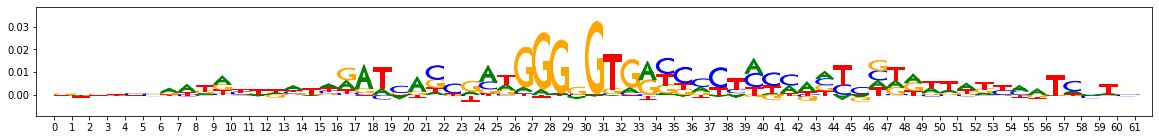

Weighted exemplar continjaccard sim


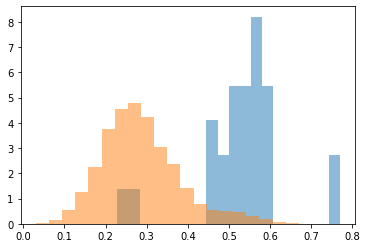

Unweighted exemplar continjaccard sim


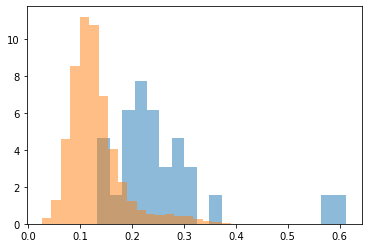

44
num seqlets 26


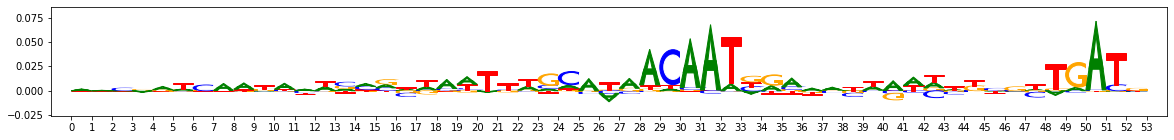

Weighted exemplar continjaccard sim


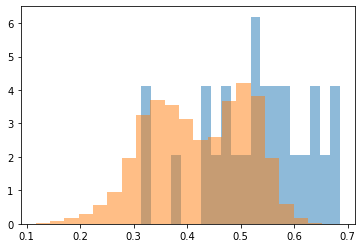

Unweighted exemplar continjaccard sim


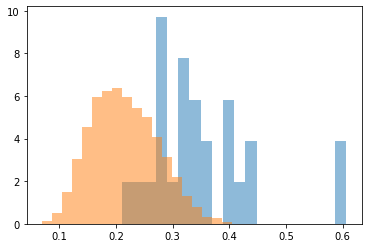

45
num seqlets 26


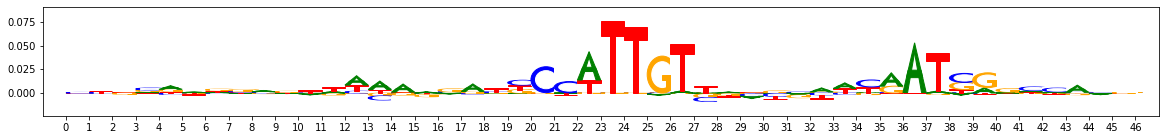

Weighted exemplar continjaccard sim


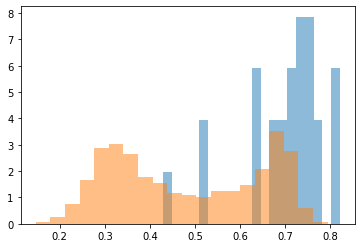

Unweighted exemplar continjaccard sim


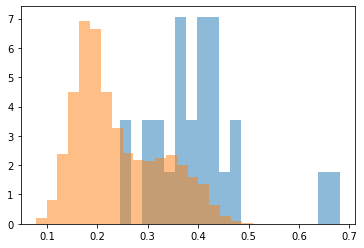

46
num seqlets 24


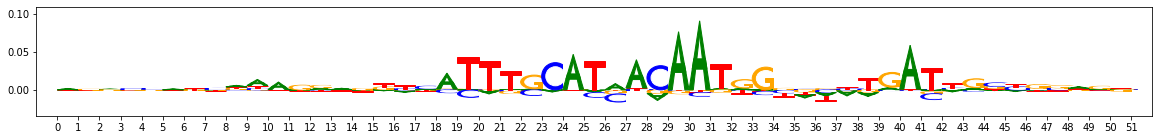

Weighted exemplar continjaccard sim


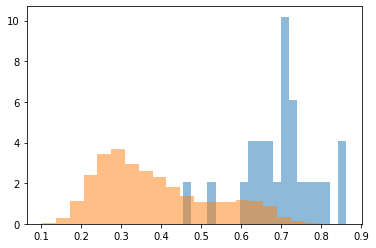

Unweighted exemplar continjaccard sim


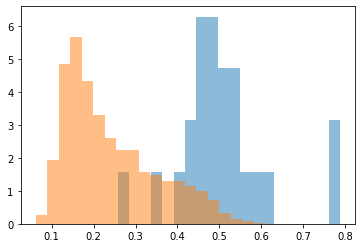

47
num seqlets 22


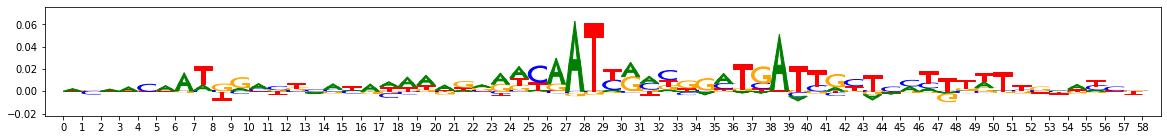

Weighted exemplar continjaccard sim


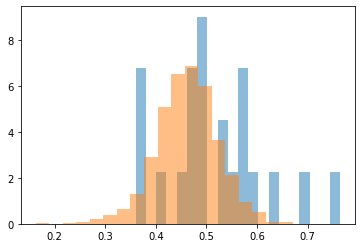

Unweighted exemplar continjaccard sim


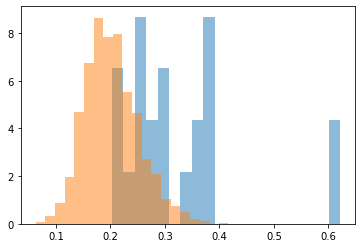

48
num seqlets 22


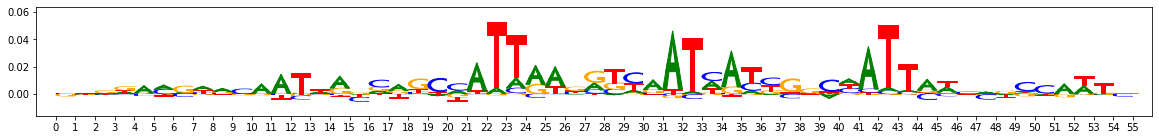

Weighted exemplar continjaccard sim


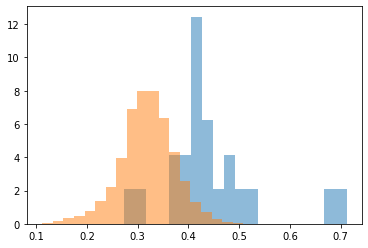

Unweighted exemplar continjaccard sim


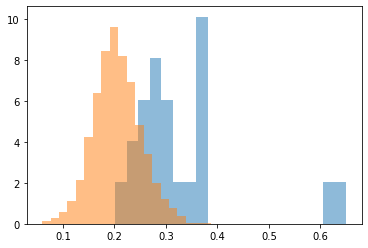

49
num seqlets 21


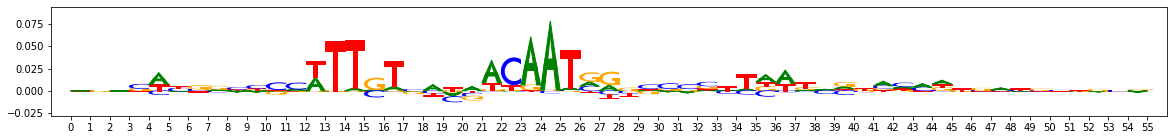

Weighted exemplar continjaccard sim


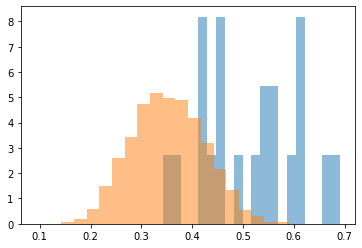

Unweighted exemplar continjaccard sim


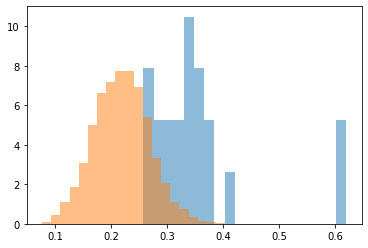

In [39]:
from matplotlib import pyplot as plt
from modisco.visualization import viz_sequence

for idx in cluster_to_weighted_exemplars:
    print(idx)
    aggregated_seqlet = cluster_idx_to_aggregated_seqlet[idx]
    print("num seqlets",len(aggregated_seqlet.seqlets))
    within_cluster_mask = refined_clustering==idx
    weighted_exemplar_sims, _, _ = cluster_to_weighted_exemplar_sims[idx]
    unweighted_exemplar_sims, _, _ = cluster_to_unweighted_exemplar_sims[idx]
    viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
    print("Weighted exemplar continjaccard sim")
    plt.hist(np.median(weighted_exemplar_sims[:, within_cluster_mask], axis=0),
             alpha=0.5, density=True, bins=20)
    plt.hist(np.median(weighted_exemplar_sims[:, within_cluster_mask==False], axis=0),
             alpha=0.5, density=True, bins=20)
    plt.show()
    #plt.hist(np.max(weighted_exemplar_sims[:, within_cluster_mask], axis=0),
    #         alpha=0.5, density=True, bins=20)
    #plt.hist(np.max(weighted_exemplar_sims[:, within_cluster_mask==False], axis=0),
    #         alpha=0.5, density=True, bins=20)
    #plt.show()
    print("Unweighted exemplar continjaccard sim")
    plt.hist(np.median(unweighted_exemplar_sims[:, within_cluster_mask], axis=0),
             alpha=0.5, density=True, bins=20)
    plt.hist(np.median(unweighted_exemplar_sims[:, within_cluster_mask==False], axis=0),
             alpha=0.5, density=True, bins=20)
    plt.show()        

debugging...

In [ ]:
np.mean(cluster_to_weighted_exemplar_sims[4][2][:,refined_clustering==4])

In [ ]:
for idx in cluster_to_exemplars:
    if (idx==4 or idx==30):
        print("Idx", idx)
        print("Top exemplar")
        viz_sequence.plot_weights(cluster_to_exemplars[idx][0]["hypcontrib_scores"].corefwd*
                                  cluster_to_exemplars[idx][0]["onehot"].corefwd)
        within_cluster_mask = refined_clustering==idx
        #display the seqlets in ascending order of similarity
        weighted_exemplar_sims,offset,isfwdmat = cluster_to_weighted_exemplar_sims[idx]
        #get the median sim
        sortby_exemplar_sims = weighted_exemplar_sims[0,:]
        #get the sort order
        argsort_exemplar_sims = np.argsort(sortby_exemplar_sims)
        seen_within_cluster = False
        for seqlet_idx in argsort_exemplar_sims:
            if (within_cluster_mask[seqlet_idx]==True):
                seen_within_cluster = True
            sim = sortby_exemplar_sims[seqlet_idx]
            if (seen_within_cluster):
                #get the offset wrt the exemplar
                offsetwrtexemplar = offset[0, seqlet_idx]
                
                #if (within_cluster_mask[seqlet_idx]):
                if (sim > 0.5):
                    print("sim",sim,"offset",offsetwrtexemplar,
                          "within cluster", within_cluster_mask[seqlet_idx], np.mean(isfwdmat[:,seqlet_idx]))
                    
                    seqlet_hypcontrib = seqlets_subsample[seqlet_idx]["hypcontrib_scores"].get_core_with_flank(
                        left=max(offsetwrtexemplar,0),
                        right=max(-offsetwrtexemplar,0),
                        is_revcomp=isfwdmat[0, seqlet_idx]==False)[max(-offsetwrtexemplar,0):
                                                                   max(-offsetwrtexemplar,0)
                                                                   +len(seqlets_subsample[0]),:]
                    viz_sequence.plot_weights(seqlet_hypcontrib*
                                              cluster_to_exemplars[idx][0]["onehot"].corefwd)
                    if isfwdmat[0, seqlet_idx]:
                        viz_sequence.plot_weights(seqlets_subsample[seqlet_idx]["contrib_scores"].corefwd)
                    else:
                        viz_sequence.plot_weights(seqlets_subsample[seqlet_idx]["contrib_scores"].corerev)
                    #TODO: display exactly what the contin jaccard saw
                    

In [ ]:
len(seqlets_subsample[0])

In [ ]:
for cluster_idx in cluster_to_exemplars:
    if (cluster_idx==30):
        print(cluster_idx)
        unweighted_exemplars = cluster_to_unweighted_exemplars[cluster_idx]
        weighted_exemplars = cluster_to_weighted_exemplars[cluster_idx]
        for exemplaridx in range(len(weighted_exemplars)):
            print(exemplaridx)
            viz_sequence.plot_weights((unweighted_exemplars[exemplaridx]["hypcontrib_scores"].corefwd
                                       *unweighted_exemplars[exemplaridx]["onehot"].corefwd))
            viz_sequence.plot_weights((weighted_exemplars[exemplaridx]["hypcontrib_scores"].corefwd
                                       *weighted_exemplars[exemplaridx]["onehot"].corefwd))

In [ ]:
reload(modisco.util)

seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets_subsample])

min_cluster_size = 20
seqlets_per_exemplar = 20

#Identify the exemplars
distmat_for_exemplars = np.log(1.0/(np.maximum(affmat,1e-7)))
zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
clusteridx_to_refinedinclustermask = {}
clusteridx_to_exemplarindices = {}
clusteridx_to_arrayforcomputingpercentile = {}
for clusteridx in range(max(the_clustering)+1):
    unrefined_in_cluster_mask = clusteridx==the_clustering
    
    aggregated_seqlet, _ = get_aggregated_seqlet(
        seqlets=seqlets_subsample, in_cluster_mask=unrefined_in_cluster_mask,
        distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
    
    if (sum(unrefined_in_cluster_mask) > min_cluster_size):
        
        print("clusteridx",clusteridx,"size",sum(unrefined_in_cluster_mask))
        
        #viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        #viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        
        median_within_to_within = np.median(affmat[unrefined_in_cluster_mask][:,unrefined_in_cluster_mask],axis=-1)
        median_within_to_out = np.median(affmat[unrefined_in_cluster_mask][:,unrefined_in_cluster_mask==False],axis=-1)
        
        #discard any seqlets where the median similarity to the outside exceeds the median sim to the inside
        #sort the seqlets by their similarity within the cluster, then march down the list until
        # we get into the situation where the min median similarity of some seqlet to within the cluster is less than
        # the max median similarity of some seqlet to outside the cluster.
        #Only retain the set of seqlets such that the min median similarity within the cluster exceeds
        # the max median similarity outside the cluster
        argsort_median_within_to_within = np.argsort(median_within_to_within)[::-1]
        sorted_median_within_to_within = median_within_to_within[argsort_median_within_to_within]
        sorted_median_within_to_out = median_within_to_out[argsort_median_within_to_within]
        runningmin_sorted_median_within_to_within = np.minimum.accumulate(sorted_median_within_to_within)
        runningmax_sorted_median_within_to_out = np.maximum.accumulate(sorted_median_within_to_out)
        
        #rel_indices_to_retain are indices in argsort_median_within_to_within, which are in turn
        # relative to whatever is in the cluster
        rel_indices_to_retain = argsort_median_within_to_within[0:
                                 [x[0] for x in enumerate((runningmin_sorted_median_within_to_within
                                                           -runningmax_sorted_median_within_to_out))
                                  if x[1] > 0][-1]+1]
        #convert rel_indices_to_retain to a boolean mask
        tmp = np.zeros(len((median_within_to_within)), dtype="bool")
        tmp[rel_indices_to_retain] = True
        rel_retainmask = tmp
        del tmp        
        #create a refined_in_cluster_mask that can be applied over all seqlets to get
        # the subset of seqlets still in the cluster after the filtering
        tmp = np.array(unrefined_in_cluster_mask)
        tmp[unrefined_in_cluster_mask] = rel_retainmask
        refined_in_cluster_mask = tmp
        del tmp    
        frac_retained = np.sum(refined_in_cluster_mask)/np.sum(unrefined_in_cluster_mask)
        print("frac retained", frac_retained)
        
        if (sum(refined_in_cluster_mask) > min_cluster_size and frac_retained > 0.8):
            
            plt.hist(median_within_to_within, density=True, bins=20, alpha=0.5)
            plt.hist(median_within_to_out, density=True, bins=20, alpha=0.5)
            plt.title("Median within-to-within, median within-to-out")
            plt.show()
            
            #plot what it looks like after the filtering...
            pruned_aggregated_seqlet, inv_seqlets_sortorder = get_aggregated_seqlet(
                                    seqlets=seqlets_subsample, in_cluster_mask=refined_in_cluster_mask,
                                    distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
            per_pos_ic = modisco.util.compute_per_position_ic(
                            ppm=pruned_aggregated_seqlet["onehot"].fwd,
                            background=np.array([0.25, 0.25, 0.25, 0.25]), pseudocount=0.001)
            perpos_count_frac_support = pruned_aggregated_seqlet.position_counts/np.max(
                                         pruned_aggregated_seqlet.position_counts)
            perpos_count_meetsthresh = perpos_count_frac_support > 0.8
            ic_weighting = per_pos_ic*perpos_count_meetsthresh
            ic_weighting = ic_weighting/np.sum(ic_weighting)
            plt.plot(np.arange(len(per_pos_ic)), ic_weighting)
            plt.show()
            
            viz_sequence.plot_weights(pruned_aggregated_seqlet["contrib_scores"].fwd)
            viz_sequence.plot_weights(pruned_aggregated_seqlet["onehot"].fwd)
            
            clusteridx_to_refinedinclustermask[clusteridx] = refined_in_cluster_mask
            indices_within_cluster = np.arange(len(refined_in_cluster_mask))[refined_in_cluster_mask]
            print("incides within:", indices_within_cluster)

            num_exemplars_for_cluster = int(np.ceil(sum(refined_in_cluster_mask)/seqlets_per_exemplar))
            #use the distmat to pick exemplars...exponentially downweight far-away things
            rel_exemplar_indices = modisco.util.facility_locator(
                                    distmat=distmat_for_exemplars[refined_in_cluster_mask][:,refined_in_cluster_mask],
                                    num_exemplars=num_exemplars_for_cluster)
            print("rel indices", rel_exemplar_indices)
            abs_exemplar_indices = indices_within_cluster[rel_exemplar_indices]
            print("abs indices:", abs_exemplar_indices)
            clusteridx_to_exemplarindices[clusteridx] = abs_exemplar_indices
            
            #Create versions of the exemplars that have bases weighted by information content
            #make sure have picked the right exemplars
            for rel_exemplar_idx in rel_exemplar_indices:
                exemplar_seqlet = pruned_aggregated_seqlet.seqlets[inv_seqlets_sortorder[rel_exemplar_idx]]
                offset_wrt_aggseqlet_start = (pruned_aggregated_seqlet.offsets[inv_seqlets_sortorder[rel_exemplar_idx]])
                print(offset_wrt_aggseqlet_start)
                viz_sequence.plot_weights(exemplar_seqlet["contrib_scores"].corefwd)
                ic_at_exemplar = ic_weighting[offset_wrt_aggseqlet_start:offset_wrt_aggseqlet_start+len(exemplar_seqlet)]
                ic_weighting_at_exemplar = ic_at_exemplar/np.sum(ic_at_exemplar)
                viz_sequence.plot_weights(exemplar_seqlet["contrib_scores"].corefwd*ic_weighting_at_exemplar[:,None])
                viz_sequence.plot_weights(exemplar_seqlet["onehot"].corefwd*ic_weighting_at_exemplar[:,None])
            
            
            assert np.min(refined_in_cluster_mask[abs_exemplar_indices])==1.0
            
            #figure out the percentiles for the similarity to the exemplars for the things that are in the cluster
            exemplar_sims_withinclust = np.max(zerodiagaffmat[refined_in_cluster_mask][:,abs_exemplar_indices],axis=-1)
            exemplar_sims_outclust = np.max(zerodiagaffmat[refined_in_cluster_mask==False][:,abs_exemplar_indices],axis=-1)
            
            #determine a threshold as
            # - a point where the density to the left of withincluster = density to the right of outerclust AND
            # - point must be >= some threshold (to filter out poor quality clusters)
            #(probably worth printing what the threshold is)
            sorted_exemplar_sims_outclust = sorted(exemplar_sims_outclust)
            sorted_exemplar_sims_withinclust = sorted(exemplar_sims_withinclust)
            for i,potential_thresh in enumerate(sorted_exemplar_sims_withinclust):
                withinclust_cdf = i/len(sorted_exemplar_sims_withinclust)
                outclust_cdf = (np.searchsorted(a=sorted_exemplar_sims_outclust, v=potential_thresh)/
                                len(sorted_exemplar_sims_outclust))
                if (withinclust_cdf >= (1-outclust_cdf)):
                    selected_thresh = potential_thresh
                    selected_thresh_withinclustcdf = withinclust_cdf
                    break
            print("threshpercentile: "+str(selected_thresh_withinclustcdf*100))   
            #plot the histogram for exemplar_sims outside to within...
            plt.hist(exemplar_sims_withinclust, bins=20, density=True, alpha=0.5)
            plt.hist(exemplar_sims_outclust, bins=20, density=True, alpha=0.5)
            plt.plot([selected_thresh, selected_thresh], [0, 1], color="black")
            plt.title("threshpercentile: "+str(selected_thresh_withinclustcdf*100))
            plt.show()
            
            
            ##compare to using ALL points in cluster
            plt.hist(np.max(zerodiagaffmat[refined_in_cluster_mask][:,refined_in_cluster_mask],axis=-1),
                     bins=20, density=True, alpha=0.5)
            plt.hist(np.max(zerodiagaffmat[refined_in_cluster_mask==False][:,refined_in_cluster_mask],axis=-1),
                     bins=20, density=True, alpha=0.5)
            plt.show()
            
            if (selected_thresh_withinclustcdf < 0.2):
                #arrayforcomputingpercentile is a sorted array of "max exemplar similarity" for all
                # the examples within the cluster for which the max exemplar sim was over the threshold
                arrayforcomputingpercentile = np.array([x for x in sorted_exemplar_sims_withinclust
                                                        if x >= selected_thresh])
                clusteridx_to_arrayforcomputingpercentile[clusteridx] = arrayforcomputingpercentile
                #assert np.searchsorted(a=arrayforcomputingpercentile, v=selected_thresh, side='right')==1
                print("weakest passing seqlet")
                #display the weakest seqlet
                abs_weakest_seqlet_idx = np.arange(len(refined_in_cluster_mask))[refined_in_cluster_mask][
                    int(min(np.array(list(enumerate(exemplar_sims_withinclust)))[
                         exemplar_sims_withinclust > selected_thresh],
                         key=lambda x: x[1])[0]) ]
                viz_sequence.plot_weights(seqlets_subsample[abs_weakest_seqlet_idx]["contrib_scores"].corefwd)


In [ ]:

#get clusteridx->seqletpercentiles
clusterremappedidx_to_seqletpercentiles = []
newtoold_clusteridx = {}
for newclusteridx,clusteridx in enumerate(sorted(clusteridx_to_arrayforcomputingpercentile.keys())):
    exemplarindicesforcluster = clusteridx_to_exemplarindices[clusteridx]
    exemplarsims = np.max(affmat[:,exemplarindicesforcluster],axis=-1)
    arrayforcomputingpercentiles = clusteridx_to_arrayforcomputingpercentile[clusteridx]
    seqletpercentiles = (np.searchsorted(a=arrayforcomputingpercentiles,
                                         v=exemplarsims, side='right'))/(len(arrayforcomputingpercentiles))
    clusterremappedidx_to_seqletpercentiles.append(seqletpercentiles)
    newtoold_clusteridx[newclusteridx] = clusteridx

maps_to_a_cluster = (np.max(clusterremappedidx_to_seqletpercentiles, 0))>0
best_cluster_match = np.argmax(clusterremappedidx_to_seqletpercentiles, axis=0)
print("fraction mapping to a cluster:", np.mean(maps_to_a_cluster))
for newclusteridx in range(len(clusterremappedidx_to_seqletpercentiles)):
    in_cluster_mask = (best_cluster_match==newclusteridx)*maps_to_a_cluster
    
    aggregated_seqlet = get_aggregated_seqlet(
        seqlets=seqlets_subsample, in_cluster_mask=in_cluster_mask,
        distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
    seqlets_in_clust, seqletoffsets, seqletsinclust_indices =\
        get_seqlets_and_seqletoffsets_for_aggregated_seqlet(
            seqlets=seqlets_subsample, in_cluster_mask=in_cluster_mask,
            distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
    
    print("idx",newclusteridx,"size", sum(in_cluster_mask),
          "minsim", np.min(clusteridx_to_arrayforcomputingpercentile[newtoold_clusteridx[newclusteridx]]) ) 
    if (newclusteridx==12):      
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        exemplarindicesforcluster = clusteridx_to_exemplarindices[newtoold_clusteridx[newclusteridx]]
        print("the exemplars", exemplarindicesforcluster)
        for exemplaridx in exemplarindicesforcluster:
            viz_sequence.plot_weights(seqlets_subsample[exemplaridx]["contrib_scores"].corefwd)
            viz_sequence.plot_weights(seqlets_subsample[exemplaridx]["hypcontrib_scores"].corefwd)
        print("seqlets inside")
        print(seqletsinclust_indices)
        for relseqletidx in range(0,len(seqlets_in_clust),10):
            viz_sequence.plot_weights(seqlets_in_clust[relseqletidx]["contrib_scores"].corefwd)
            viz_sequence.plot_weights(seqlets_in_clust[relseqletidx]["hypcontrib_scores"].corefwd)
            print(seqletsinclust_indices[relseqletidx], "percentile", )
            print("aff:",affmat[seqletsinclust_indices[relseqletidx],exemplarindicesforcluster])
#        modisco.util.viz_seqlets_with_offsets(seqlets=seqlets_in_clust, offsets=seqletoffsets,
#                                              trackname="contrib_scores", num_to_plot=10)

#display the things mapping to each cluster.

#argmaxcluster = np.argmax(clusterremappedidx_to_seqletpercentiles, 0)
#    
#new_cluster_mapping = []
#for seqletidx in range(len(seqlets_subsample)):
#    forseqlet_clusteridx_to_percentile = {}
    
        
    

#map a seqlet to a cluster if:
# (1) its median exemplar similarity is better than that of [xth percentile] in the cluster AND
# (2) it has the highest percentile of all the clusters it maps to
#[revisit later: repeat until some kind of convergence, hopefully?]
# then use to soak
#...or could also go the SVM route...

#(Have a hypothetical exemplar?)
#hmm...how do I decide that something is not in the cluster - do I need exemplars for the outside?

#other idea: start w/ exemplars, then "grow" them out until stable assignment?
#start w. exemplars, merge based on exemplar sims to other exemplars, once merged, grow.

In [ ]:
reload(modisco.core)
reload(modisco.util)

seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets_subsample])

min_cluster_support = 20

seqlets_so_far = 0
print("Numbed of clusters:",np.max(the_clustering)+1)
for idx in range(max(the_clustering)+1):
    in_cluster_mask = idx==the_clustering
    num_in_cluster = np.sum(in_cluster_mask)
    seqlets_so_far += num_in_cluster
    print("Coverage:", )
    print("Cluster idx",idx,"size",num_in_cluster)
    if (num_in_cluster > min_cluster_support):
        #find an anchor for the cluster as the one with the minimum total distance to all the others
        #ok this doesn't work that well
        #anchor = np.argmin(np.sum(distmat[:,in_cluster_mask],axis=-1)+((in_cluster_mask==False)*np.inf))
        anchor = np.argmax(seqletimps*in_cluster_mask) #highest imp for anchor - this works better
        #sortinfo = np.argsort(seqletimps[in_cluster_mask])[::-1] #np.argsort(distmat[in_cluster_mask, anchor])
        sortinfo = np.argsort(np.median(distmat[in_cluster_mask][:,in_cluster_mask], axis=-1))
        isfwdinfo = isfwdmat[anchor, in_cluster_mask][sortinfo]
        #offsetsinfo gives the offset w.r.t. the start of anchor
        offsetsinfo = offsets[anchor, in_cluster_mask][sortinfo]
        
        seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in zip(seqlets_subsample, in_cluster_mask) if incluster]
        seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in sortinfo]
        oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                       for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
        aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:],
                                                          offsets=offsetsinfo[:])
        
        #viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].fwd
                                  - np.mean(aggregated_seqlet["hypcontrib_scores"].fwd, axis=-1)[:,None])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        #viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].rev
                                  - np.mean(aggregated_seqlet["hypcontrib_scores"].rev, axis=-1)[:,None])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].rev)
        #plot the distribution of pairwise dissimilarities within the cluster
        zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
        print("Pairwise within v pairwise out-to-within")
        plt.hist(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.hist(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Median within v median out-to-within")
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Median within, median within-to-out")
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Max within v max out-to-within")
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Max within v max within-to-out")
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)        
        plt.show()
        
        #viz some number
        """print("Visualizing seqlets")
        modisco.util.viz_seqlets_with_offsets(
            seqlets=oriented_seqlets_in_cluster,
            offsets=offsetsinfo, trackname="contrib_scores", num_to_plot=10)
        print("Done visualizing seqlets")"""
        
        #plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
        #         - np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
        #         - np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()

In [ ]:
#compare clusters
from modisco.visualization import viz_sequence
cluster1 = 0
cluster2 = 2
incluster1mask = cluster1==the_clustering
incluster2mask = cluster2==the_clustering
zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))

cluster1_within = plt.hist(zerodiagaffmat[incluster1mask][:,incluster1mask].ravel(),
                           bins=50, density=True, alpha=0.3)
cluster2_within = plt.hist(zerodiagaffmat[incluster2mask][:,incluster2mask].ravel(),
                           bins=50, density=True, alpha=0.3)
cluster12_between = plt.hist(zerodiagaffmat[incluster1mask][:,incluster2mask].ravel(),
                             bins=50, density=True, alpha=0.3)
cluster12_allelse = plt.hist(zerodiagaffmat[(incluster1mask+incluster2mask > 0)][:,(incluster1mask+incluster2mask)==0].ravel(),
                             bins=50, density=True, alpha=0.3)
plt.show()

cluster1_within = plt.hist(np.median(zerodiagaffmat[incluster1mask][:,incluster1mask],axis=-1),
                           bins=50, density=True, alpha=0.3)
cluster2_within = plt.hist(np.median(zerodiagaffmat[incluster2mask][:,incluster2mask],axis=-1),
                           bins=50, density=True, alpha=0.3)
cluster12_between = plt.hist(np.median(zerodiagaffmat[incluster1mask][:,incluster2mask],axis=-1),
                             bins=50, density=True, alpha=0.3)
cluster12_allelse = plt.hist(np.median(zerodiagaffmat[(incluster1mask+incluster2mask > 0)][:,(incluster1mask+incluster2mask)==0],axis=-1),
                             bins=50, density=True, alpha=0.3)
plt.show()

#find an example with very high within-cluster similarity but high dissim to the other cluster
cluster1typical = np.argmax(np.median(zerodiagaffmat[:,incluster1mask],axis=-1) - np.median(zerodiagaffmat[:,incluster2mask],axis=-1))
print(cluster1typical)
viz_sequence.plot_weights(seqlets_subsample[cluster1typical]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))
viz_sequence.plot_weights(seqlets_subsample[cluster1typical]["hypcontrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))

#find an example with very high within-cluster similarity but high dissim to the other cluster
cluster2typical = np.argmax(np.median(zerodiagaffmat[:,incluster2mask],axis=-1) - np.median(zerodiagaffmat[:,incluster1mask],axis=-1))
print(cluster2typical)
viz_sequence.plot_weights(seqlets_subsample[cluster2typical]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))
viz_sequence.plot_weights(seqlets_subsample[cluster2typical]["hypcontrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))